Data Preprocessing
---
From https://github.com/shubham3008/MultitaskActiveLearning


In [88]:
#ALL IMPORTS
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import math
import statistics as stat
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import json
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from functools import partial
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from modAL.batch import uncertainty_batch_sampling, ranked_batch
from modAL.models import ActiveLearner
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler 
from numpy import quantile, where, random
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib as mpl
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
import math
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
le = LabelEncoder()

In [89]:
batch_size = 50
n_train = 100
n_test = 1000
num_queries = 20

####Data handling

In [90]:
def get_data(name):
  if name == 'imdb':
    movie_data = pd.read_csv('./Datasets/movie_metadata.csv')
    movie_data.drop_duplicates(inplace=True)
    movie_data.loc[:,'genres'] = movie_data.loc[:,'genres'].apply(lambda x: x.split('|'))

    genres = []
    for x in movie_data.genres:
      for g in x:
        if g not in genres:
          genres.append(g)

    for g in genres:
      movie_data.loc[:,g] = movie_data.loc[:,'genres'].apply(lambda x: int(g in x))

    movie_data.drop(["director_name","actor_2_name","movie_title","genres","actor_1_name","actor_3_name","plot_keywords","movie_imdb_link","cast_total_facebook_likes"],axis=1, inplace = True)
    movie_data.dropna(inplace=True)

    movie_data["imdb_score"] = movie_data["imdb_score"].apply(float)
    movie_data.loc[movie_data['imdb_score'].between(8,10), 'imdb_score'] = 100.0
    movie_data.loc[movie_data['imdb_score'].between(5,7.99), 'imdb_score'] = 50.0
    movie_data.loc[movie_data['imdb_score'].between(0,4.992), 'imdb_score'] = 30.0
    movie_data["imdb_score"] = movie_data["imdb_score"].apply(str)
    movie_data.loc[movie_data['imdb_score'] == "100.0", 'imdb_score'] = "GOOD"
    movie_data.loc[movie_data['imdb_score'] == "50.0", 'imdb_score'] = "AVERAGE"
    movie_data.loc[movie_data['imdb_score'] == "30.0", 'imdb_score'] = "BAD"

    ratings = movie_data["content_rating"].unique()
    for rate in ratings:
        if rate == "M":
            movie_data.loc[movie_data['content_rating'] == rate, 'content_rating'] = "PG"
        elif rate == "GP":
            movie_data.loc[movie_data['content_rating'] == rate, 'content_rating'] = "PG"
        elif rate == "Unrated":
            movie_data.loc[movie_data['content_rating'] == rate, 'content_rating'] = "Not Rated"
        elif rate == "Passed":
            movie_data.loc[movie_data['content_rating'] == rate, 'content_rating'] = "Approved"
        elif rate == "X":
            movie_data.loc[movie_data['content_rating'] == rate, 'content_rating'] = "NC-17"

    movie_data.loc[movie_data['gross'].between(0,15000000.0), 'gross'] = 0.0
    movie_data.loc[movie_data['gross'].between(1500000.01,762000000.0), 'gross'] = 1.0
    movie_data = pd.get_dummies(movie_data,columns=['color','language','country'],drop_first=True)
    target1 = le.fit_transform(movie_data["imdb_score"])
    target2 = le.fit_transform(movie_data["content_rating"])
    target3 = le.fit_transform(movie_data["gross"])
    X_final = movie_data.drop(["imdb_score", "content_rating", "content_rating"],axis=1)

  elif name == 'mushroom':
    mushroom_data = pd.read_csv('./Datasets/mushroom.csv')
    mushroom_data = mushroom_data[mushroom_data['stalk-root']!='?']
    mushroom_data = pd.get_dummies(mushroom_data,columns=['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
          'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
          'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
          'stalk-surface-below-ring', 'stalk-color-above-ring',
          'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
          'ring-type', 'spore-print-color'],drop_first=True)
    target1 = le.fit_transform(mushroom_data["Class"])
    target2 = le.fit_transform(mushroom_data["population"])
    target3 = le.fit_transform(mushroom_data["habitat"])
    X_final = mushroom_data.drop(["Class", "population", "habitat"],axis=1)
  
  elif name == 'census':
    census_data = pd.read_csv('./Datasets/census.csv',names=['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','income']) 
    census_data=census_data.drop_duplicates()
    for col in census_data.columns:
      census_data = census_data[census_data[col]!=' ?']
    census_data.loc[census_data.income==' <=50K.','income'] = ' <=50K' 
    census_data.loc[census_data.income==' >50K.','income'] = ' >50K'
    census_data = pd.get_dummies(census_data,columns=['education','occupation','relationship','race','sex','native-country'],drop_first=True)
    target1 = le.fit_transform(census_data["income"])
    target2 = le.fit_transform(census_data["marital-status"])
    target3 = le.fit_transform(census_data["workclass"])
    X_final = census_data.drop(["income", "marital-status", "workclass"],axis=1)
  
  elif name == 'bank':
    bank_data = pd.read_csv('./Datasets/bank-additional.csv')
    for col in bank_data.columns:
      bank_data = bank_data[bank_data[col]!='unknown']
    bank_data = pd.get_dummies(bank_data,columns=['job','education','default','contact','month','day_of_week','poutcome','marital'],drop_first=True)
    target1 = le.fit_transform(bank_data["y"])
    target2 = le.fit_transform(bank_data["loan"])
    target3 = le.fit_transform(bank_data["housing"])
    X_final = bank_data.drop(["y", "loan", "housing"],axis=1)

  elif name == 'intention':
    intention_data = pd.read_csv('./Datasets/online_shoppers_intention.csv')
    intention_data = intention_data.drop_duplicates()
    intention_data = intention_data[intention_data['VisitorType']!='Other']
    intention_data = pd.get_dummies(intention_data,columns=['Month','Weekend'],drop_first=True)        
    target1 = le.fit_transform(intention_data["Revenue"])
    target2 = le.fit_transform(intention_data["VisitorType"])
    target3 = le.fit_transform(intention_data["SpecialDay"])
    X_final = intention_data.drop(["Revenue", "VisitorType", "SpecialDay"],axis=1)

  elif name == 'anuran':
    anuran_data = pd.read_csv('./Datasets/Frogs_MFCCs.csv')
    anuran_data.drop(columns='RecordID',inplace=True)
    target1 = le.fit_transform(anuran_data["Family"])
    target2 = le.fit_transform(anuran_data["Genus"])
    target3 = le.fit_transform(anuran_data["Species"])
    X_final = anuran_data.drop(["Family", "Genus", "Species"],axis=1)
  
  elif name == 'telco':
    telco_data = pd.read_csv('./Datasets/telco.csv')
    telco_data.drop(columns=['customerID'],inplace=True)
    telco_data = telco_data.drop_duplicates()
    telco_data = telco_data[telco_data.TotalCharges!=' ']
    telco_data = pd.get_dummies(telco_data,columns=['gender','Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaperlessBilling'],drop_first=True)
    target1 = le.fit_transform(telco_data["Churn"])
    target2 = le.fit_transform(telco_data["Contract"])
    target3 = le.fit_transform(telco_data["PaymentMethod"])
    X_final = telco_data.drop(["Churn", "Contract", "PaymentMethod"],axis=1)

  elif name == 'paris':
    paris_data = pd.read_csv('./Datasets/ParisHousingClass.csv')
    paris_data.drop(columns='made',inplace=True)
    target1 = le.fit_transform(paris_data["category"])
    target2 = le.fit_transform(paris_data["isNewBuilt"])
    target3 = le.fit_transform(paris_data["hasStorageRoom"])
    X_final = paris_data.drop(["category", "isNewBuilt", "hasStorageRoom"],axis=1)
  
  elif name == 'smoking':
    smoking_data = pd.read_csv('./Datasets/smoking.csv')
    smoking_data.drop(columns=['ID','oral'],inplace=True)
    smoking_data = smoking_data.drop_duplicates()
    smoking_data = pd.get_dummies(smoking_data,columns=['gender'],drop_first=True)
    target1 = le.fit_transform(smoking_data["smoking"])
    target2 = le.fit_transform(smoking_data["tartar"])
    target3 = le.fit_transform(smoking_data["dental caries"])
    X_final = smoking_data.drop(["smoking", "tartar", "dental caries"],axis=1)
  
  elif name == 'flight':
    flight_data = pd.read_csv('./Datasets/flight.csv')
    flight_data.dropna(inplace=True)
    flight_data = pd.get_dummies(flight_data,columns=['Gender','Type of Travel'],drop_first=True)
    target1 = le.fit_transform(flight_data["satisfaction"])
    target2 = le.fit_transform(flight_data["Customer Type"])
    target3 = le.fit_transform(flight_data["Class"])
    X_final = flight_data.drop(["satisfaction", "Customer Type", "Class"],axis=1)
  
  else:
    raise ValueError('Incorrect dataset')
  
  return X_final, target1, target2, target3

####Implementation Helpers

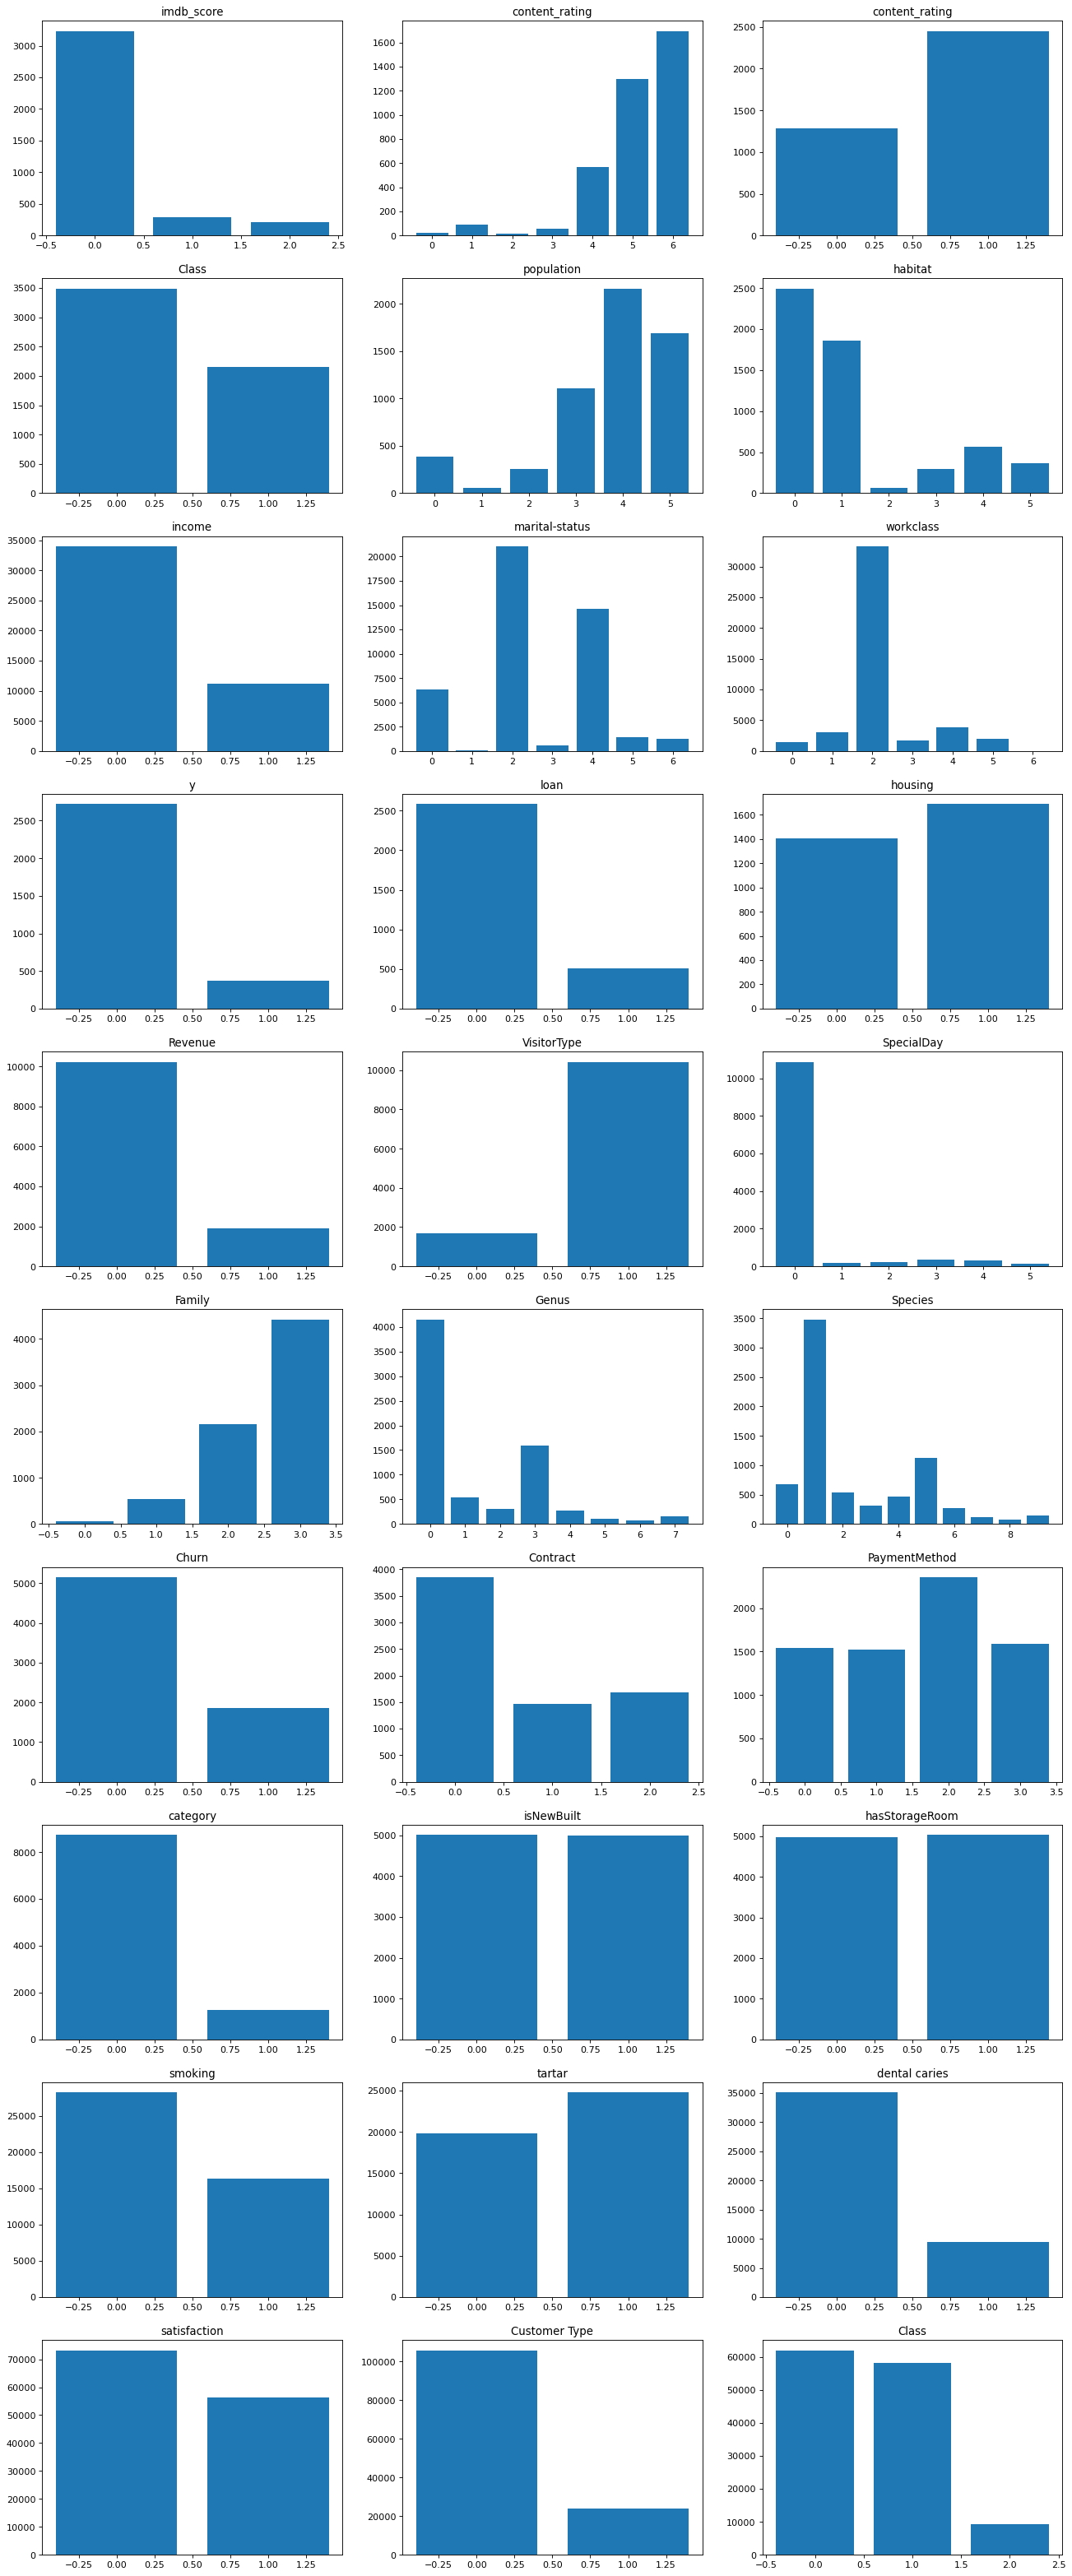

In [98]:
def plotDist(arr, title):
  values, counts = np.unique(arr, return_counts=True)
  lis = np.asarray((values, counts)).T
  x, y = zip(*lis) # unpack a list of pairs into two tuples
  # plt.plot(x, y)
  plt.bar(x,y)

  plt.title(title)
  # plt.show()

plt.figure(figsize=(20, 50), dpi=80)

data = json.load(open('data_structure.json'))
dataKeys = list(data.keys())
for i in range(len(data)):
  key = dataKeys[i]
  dataSet = data[key]
  target, t1, t2, t3 = get_data(dataSet['name'])
  
  plt.subplot(10, 3, i*3+1)
  plotDist(t1, dataSet['t1'])
  plt.subplot(10, 3, i*3+2)
  plotDist(t2, dataSet['t2'])
  plt.subplot(10,3, i*3+3)
  plotDist(t3, dataSet['t3'])
plt.show()




In [4]:
def stratify_samples(X_raw_a, y_raw_1_a, y_raw_2_a, y_raw_3_a, num_classes1, num_classes2, num_classes3):
    
    train_instances = []
    train_instances_y1 = []
    train_instances_y2 = []
    train_instances_y3 = []
    
    counts_1 = [0 for i in range(num_classes1)]
    counts_2 = [0 for i in range(num_classes2)]
    counts_3 = [0 for i in range(num_classes3)]
    
    counter_inst = 0
    for q in range(len(y_raw_1_a)):
        for i in range(num_classes1):
            if ((y_raw_1_a[q-counter_inst]) == i) and (counts_1[i]<10):
                train_instances.append(X_raw_a[q-counter_inst])
                train_instances_y1.append(y_raw_1_a[q-counter_inst])
                train_instances_y2.append(y_raw_2_a[q-counter_inst])
                train_instances_y3.append(y_raw_3_a[q-counter_inst])
                
                X_raw_a = np.delete(X_raw_a,q-counter_inst,axis=0)
                y_raw_1_a = np.delete(y_raw_1_a,q-counter_inst,axis=0)
                y_raw_2_a = np.delete(y_raw_2_a,q-counter_inst,axis=0)
                y_raw_3_a = np.delete(y_raw_3_a,q-counter_inst,axis=0)
                counter_inst = counter_inst + 1
                counts_1[i] = counts_1[i] + 1
                break

    counter_inst = 0
    for q in range(len(y_raw_2_a)):
        for i in range(num_classes2):
            if ((y_raw_2_a[q-counter_inst]) == i) and (counts_2[i]<10):
                train_instances.append(X_raw_a[q-counter_inst])
                train_instances_y1.append(y_raw_1_a[q-counter_inst])
                train_instances_y2.append(y_raw_2_a[q-counter_inst])
                train_instances_y3.append(y_raw_3_a[q-counter_inst])
                
                X_raw_a = np.delete(X_raw_a,q-counter_inst,axis=0)
                y_raw_1_a = np.delete(y_raw_1_a,q-counter_inst,axis=0)
                y_raw_2_a = np.delete(y_raw_2_a,q-counter_inst,axis=0)
                y_raw_3_a = np.delete(y_raw_3_a,q-counter_inst,axis=0)
                counter_inst = counter_inst + 1
                counts_2[i] = counts_2[i] + 1
                break

    counter_inst = 0
    for q in range(len(y_raw_3_a)):
        for i in range(num_classes3):
            if ((y_raw_3_a[q-counter_inst]) == i) and (counts_3[i]<10):
                train_instances.append(X_raw_a[q-counter_inst])
                train_instances_y1.append(y_raw_1_a[q-counter_inst])
                train_instances_y2.append(y_raw_2_a[q-counter_inst])
                train_instances_y3.append(y_raw_3_a[q-counter_inst])
                
                X_raw_a = np.delete(X_raw_a,q-counter_inst,axis=0)
                y_raw_1_a = np.delete(y_raw_1_a,q-counter_inst,axis=0)
                y_raw_2_a = np.delete(y_raw_2_a,q-counter_inst,axis=0)
                y_raw_3_a = np.delete(y_raw_3_a,q-counter_inst,axis=0)
                counter_inst = counter_inst + 1
                counts_3[i] = counts_3[i] + 1
                break
    
    return train_instances, len(train_instances), train_instances_y1, train_instances_y2, train_instances_y3, X_raw_a, y_raw_1_a, y_raw_2_a, y_raw_3_a

In [5]:
def high_probabilities(target_prob):
    prob_arr_temp = [-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1]
    prob_array = []
    for i in range(target_prob.shape[0]):
        for j in range(target_prob.shape[1]):
            prob_arr_temp[j] = target_prob[i][j]
        max = np.amax(prob_arr_temp)
        class_index = np.where(prob_arr_temp == max)
        prob_array.append([max,class_index[0][0],i])
        # print([max,class_index[0][0],i])
    return prob_array

In [6]:
def find_min(tar_probs, num_sample):
    sample_size = num_sample
    temp_tar_probs = tar_probs
    que_instances = []
    temp_tar_probs = sorted(temp_tar_probs, key=lambda x:x[0])
    count_stop = 1
    for t in range(50):
        if ((count_stop <= sample_size) and (int(temp_tar_probs[t][2]) < len(temp_tar_probs))):
            que_instances.append(int(temp_tar_probs[t][2]))
            count_stop = count_stop + 1
            
    return que_instances

In [7]:
#Obtaining Query Samples
def obt_samples(tar_probs, pool_x, pool_y_1, pool_y_2, pool_y_3, query_indexs, query_samples_xs, query_samples_y_1s, query_samples_y_2s, query_samples_y_3s, tar_probs_2, tar_probs_3, num_sample):

    q_indic = find_min(tar_probs, num_sample)
    q_indic = sorted(q_indic, reverse=True)
    for p in range(len(q_indic)):
        q_ind = q_indic[p]
        query_indexs.append(q_ind)

        query_samples_xs.append(pool_x[q_ind])
        query_samples_y_1s.append(pool_y_1[q_ind])
        query_samples_y_2s.append(pool_y_2[q_ind])
        query_samples_y_3s.append(pool_y_3[q_ind])
        
    for p in range(len(q_indic)):
        q_ind = q_indic[p]
        pool_x = np.delete(pool_x,q_ind,axis=0)
        pool_y_1 = np.delete(pool_y_1,q_ind,axis=0)
        pool_y_2 = np.delete(pool_y_2,q_ind,axis=0)
        pool_y_3 = np.delete(pool_y_3,q_ind,axis=0)
        tar_probs = np.delete(tar_probs,q_ind,axis=0)
        tar_probs_2 = np.delete(tar_probs_2,q_ind,axis=0)
        tar_probs_3 = np.delete(tar_probs_3,q_ind,axis=0)
        
    return pool_x, pool_y_1, pool_y_2, pool_y_3, tar_probs, query_indexs, query_samples_xs, query_samples_y_1s, query_samples_y_2s, query_samples_y_3s, tar_probs_2, tar_probs_3

In [8]:
def find_samples(X_pools, Y_pools_1, Y_pools_2, Y_pools_3, tar_1_proba, tar_2_proba, tar_3_proba, num_samples1=15, num_samples2=15, num_samples3=15):
    tar_1_high_probs = high_probabilities(tar_1_proba)
    tar_2_high_probs = high_probabilities(tar_2_proba)
    tar_3_high_probs = high_probabilities(tar_3_proba)

    query_index = []
    query_samples_x = []
    query_samples_y_1 = []
    query_samples_y_2 = []
    query_samples_y_3 = []

    X_pools, Y_pools_1, Y_pools_2, Y_pools_3, tar_1_high_probs, query_index, query_samples_x, query_samples_y_1, query_samples_y_2, query_samples_y_3, tar_2_high_probs, tar_3_high_probs = obt_samples(tar_1_high_probs, X_pools, Y_pools_1, Y_pools_2, Y_pools_3, query_index, query_samples_x, query_samples_y_1, query_samples_y_2, query_samples_y_3, tar_2_high_probs, tar_3_high_probs, num_samples1)
    X_pools, Y_pools_1, Y_pools_2, Y_pools_3, tar_2_high_probs, query_index, query_samples_x, query_samples_y_1, query_samples_y_2, query_samples_y_3, tar_1_high_probs, tar_3_high_probs = obt_samples(tar_2_high_probs, X_pools, Y_pools_1, Y_pools_2, Y_pools_3, query_index, query_samples_x, query_samples_y_1, query_samples_y_2, query_samples_y_3, tar_1_high_probs, tar_3_high_probs, num_samples2)
    X_pools, Y_pools_1, Y_pools_2, Y_pools_3, tar_3_high_probs, query_index, query_samples_x, query_samples_y_1, query_samples_y_2, query_samples_y_3, tar_1_high_probs, tar_2_high_probs = obt_samples(tar_3_high_probs, X_pools, Y_pools_1, Y_pools_2, Y_pools_3, query_index, query_samples_x, query_samples_y_1, query_samples_y_2, query_samples_y_3, tar_1_high_probs, tar_2_high_probs, num_samples3)
    
    return X_pools, Y_pools_1, Y_pools_2, Y_pools_3, query_samples_x, query_samples_y_1, query_samples_y_2, query_samples_y_3

####Implementation

In [9]:
def mlsample(X_final, target1, target2, target3, columns):
  tempdf = pd.DataFrame(X_final,columns=columns)
  diff1, diff2, diff3 = int(np.diff(np.bincount(target1))), int(np.diff(np.bincount(target2))), int(np.diff(np.bincount(target3)))
  max1, max2, max3 = [int(x>0) for x in [diff1, diff2, diff3]]

  tempdf['target1'] = target1
  tempdf['target2'] = target2
  tempdf['target3'] = target3

  diff1, diff2, diff3 = abs(diff1), abs(diff2), abs(diff3)

  # print(diff1,diff2,diff3)
  # try:
  if diff1 == min(diff1,diff2,diff3):
    # print('Start replicating target 1')
    tempdf = tempdf.append(tempdf[tempdf['target1']!=max1].sample(max(1,diff1), replace=True, random_state=42), ignore_index=True)
    diff1, diff2, diff3 = int(np.diff(np.bincount(tempdf['target1']))), int(np.diff(np.bincount(tempdf['target2']))), int(np.diff(np.bincount(tempdf['target3'])))
    max1, max2, max3 = [int(x>0) for x in [diff1, diff2, diff3]]
    diff1, diff2, diff3 = abs(diff1), abs(diff2), abs(diff3)
    # print(diff1,diff2,diff3)

    if diff2 == min(diff2,diff3):
      # print('replicate 2 and then 3')
      tempdf = tempdf.append(tempdf[(tempdf['target2']!=max2) & (tempdf['target1']!=0)].sample(max(1,diff2//2), replace=True, random_state=42), ignore_index=True)
      tempdf = tempdf.append(tempdf[(tempdf['target2']!=max2) & (tempdf['target1']!=1)].sample(max(1,diff2//2), replace=True, random_state=42), ignore_index=True)
      diff1, diff2, diff3 = int(np.diff(np.bincount(tempdf['target1']))), int(np.diff(np.bincount(tempdf['target2']))), int(np.diff(np.bincount(tempdf['target3'])))
      max1, max2, max3 = [int(x>0) for x in [diff1, diff2, diff3]]
      diff1, diff2, diff3 = abs(diff1), abs(diff2), abs(diff3)
      # print(diff1,diff2,diff3)

      tempdf = tempdf.append(tempdf[(tempdf['target3']!=max3) & (tempdf['target2']==0) & (tempdf['target1']==0)].sample(max(1,diff3//4), replace=True, random_state=42), ignore_index=True)
      tempdf = tempdf.append(tempdf[(tempdf['target3']!=max3) & (tempdf['target2']==0) & (tempdf['target1']==1)].sample(max(1,diff3//4), replace=True, random_state=42), ignore_index=True)
      tempdf = tempdf.append(tempdf[(tempdf['target3']!=max3) & (tempdf['target2']==1) & (tempdf['target1']==0)].sample(max(1,diff3//4), replace=True, random_state=42), ignore_index=True)
      tempdf = tempdf.append(tempdf[(tempdf['target3']!=max3) & (tempdf['target2']==1) & (tempdf['target1']==1)].sample(max(1,diff3//4), replace=True, random_state=42), ignore_index=True)
      diff1, diff2, diff3 = int(np.diff(np.bincount(tempdf['target1']))), int(np.diff(np.bincount(tempdf['target2']))), int(np.diff(np.bincount(tempdf['target3'])))
      max1, max2, max3 = [int(x>0) for x in [diff1, diff2, diff3]]
      diff1, diff2, diff3 = abs(diff1), abs(diff2), abs(diff3)
      # print(diff1,diff2,diff3)

    else:
      # print('replicate 3 and then 2')
      tempdf = tempdf.append(tempdf[(tempdf['target3']!=max3) & (tempdf['target1']!=0)].sample(max(1,diff3//2), replace=True, random_state=42), ignore_index=True)
      tempdf = tempdf.append(tempdf[(tempdf['target3']!=max3) & (tempdf['target1']!=1)].sample(max(1,diff3//2), replace=True, random_state=42), ignore_index=True)
      diff1, diff2, diff3 = int(np.diff(np.bincount(tempdf['target1']))), int(np.diff(np.bincount(tempdf['target2']))), int(np.diff(np.bincount(tempdf['target3'])))
      max1, max2, max3 = [int(x>0) for x in [diff1, diff2, diff3]]
      diff1, diff2, diff3 = abs(diff1), abs(diff2), abs(diff3)
      # print(diff1,diff2,diff3)

      tempdf = tempdf.append(tempdf[(tempdf['target2']!=max2) & (tempdf['target3']==0) & (tempdf['target1']==0)].sample(max(1,diff2//4), replace=True, random_state=42), ignore_index=True)
      tempdf = tempdf.append(tempdf[(tempdf['target2']!=max2) & (tempdf['target3']==0) & (tempdf['target1']==1)].sample(max(1,diff2//4), replace=True, random_state=42), ignore_index=True)
      tempdf = tempdf.append(tempdf[(tempdf['target2']!=max2) & (tempdf['target3']==1) & (tempdf['target1']==0)].sample(max(1,diff2//4), replace=True, random_state=42), ignore_index=True)
      tempdf = tempdf.append(tempdf[(tempdf['target2']!=max2) & (tempdf['target3']==1) & (tempdf['target1']==1)].sample(max(1,diff2//4), replace=True, random_state=42), ignore_index=True)
      diff1, diff2, diff3 = int(np.diff(np.bincount(tempdf['target1']))), int(np.diff(np.bincount(tempdf['target2']))), int(np.diff(np.bincount(tempdf['target3'])))
      max1, max2, max3 = [int(x>0) for x in [diff1, diff2, diff3]]
      diff1, diff2, diff3 = abs(diff1), abs(diff2), abs(diff3)
      # print(diff1,diff2,diff3)


  elif diff2 == min(diff1,diff2,diff3):
    # print('Start replicating target 2')
    tempdf = tempdf.append(tempdf[tempdf['target2']!=max2].sample(max(1,diff2), replace=True, random_state=42), ignore_index=True)
    diff1, diff2, diff3 = int(np.diff(np.bincount(tempdf['target1']))), int(np.diff(np.bincount(tempdf['target2']))), int(np.diff(np.bincount(tempdf['target3'])))
    max1, max2, max3 = [int(x>0) for x in [diff1, diff2, diff3]]
    diff1, diff2, diff3 = abs(diff1), abs(diff2), abs(diff3)
    # print(diff1,diff2,diff3)

    if diff1 == min(diff1,diff3):
      # print('replicate 1 and then 3')
      tempdf = tempdf.append(tempdf[(tempdf['target1']!=max1) & (tempdf['target2']!=0)].sample(max(1,diff1//2), replace=True, random_state=42), ignore_index=True)
      tempdf = tempdf.append(tempdf[(tempdf['target1']!=max1) & (tempdf['target2']!=1)].sample(max(1,diff1//2), replace=True, random_state=42), ignore_index=True)
      diff1, diff2, diff3 = int(np.diff(np.bincount(tempdf['target1']))), int(np.diff(np.bincount(tempdf['target2']))), int(np.diff(np.bincount(tempdf['target3'])))
      max1, max2, max3 = [int(x>0) for x in [diff1, diff2, diff3]]
      diff1, diff2, diff3 = abs(diff1), abs(diff2), abs(diff3)
      # print(diff1,diff2,diff3)

      tempdf = tempdf.append(tempdf[(tempdf['target3']!=max3) & (tempdf['target2']==0) & (tempdf['target1']==0)].sample(max(1,diff3//4), replace=True, random_state=42), ignore_index=True)
      tempdf = tempdf.append(tempdf[(tempdf['target3']!=max3) & (tempdf['target2']==0) & (tempdf['target1']==1)].sample(max(1,diff3//4), replace=True, random_state=42), ignore_index=True)
      tempdf = tempdf.append(tempdf[(tempdf['target3']!=max3) & (tempdf['target2']==1) & (tempdf['target1']==0)].sample(max(1,diff3//4), replace=True, random_state=42), ignore_index=True)
      tempdf = tempdf.append(tempdf[(tempdf['target3']!=max3) & (tempdf['target2']==1) & (tempdf['target1']==1)].sample(max(1,diff3//4), replace=True, random_state=42), ignore_index=True)
      diff1, diff2, diff3 = int(np.diff(np.bincount(tempdf['target1']))), int(np.diff(np.bincount(tempdf['target2']))), int(np.diff(np.bincount(tempdf['target3'])))
      max1, max2, max3 = [int(x>0) for x in [diff1, diff2, diff3]]
      diff1, diff2, diff3 = abs(diff1), abs(diff2), abs(diff3)
      # print(diff1,diff2,diff3)

    else:
      # print('replicate 3 and then 1')
      tempdf = tempdf.append(tempdf[(tempdf['target3']!=max3) & (tempdf['target2']!=0)].sample(max(1,diff3//2), replace=True, random_state=42), ignore_index=True)
      tempdf = tempdf.append(tempdf[(tempdf['target3']!=max3) & (tempdf['target2']!=1)].sample(max(1,diff3//2), replace=True, random_state=42), ignore_index=True)
      diff1, diff2, diff3 = int(np.diff(np.bincount(tempdf['target1']))), int(np.diff(np.bincount(tempdf['target2']))), int(np.diff(np.bincount(tempdf['target3'])))
      max1, max2, max3 = [int(x>0) for x in [diff1, diff2, diff3]]
      diff1, diff2, diff3 = abs(diff1), abs(diff2), abs(diff3)
      # print(diff1,diff2,diff3)

      tempdf = tempdf.append(tempdf[(tempdf['target1']!=max1) & (tempdf['target3']==0) & (tempdf['target2']==0)].sample(max(1,diff1//4), replace=True, random_state=42), ignore_index=True)
      tempdf = tempdf.append(tempdf[(tempdf['target1']!=max1) & (tempdf['target3']==0) & (tempdf['target2']==1)].sample(max(1,diff1//4), replace=True, random_state=42), ignore_index=True)
      tempdf = tempdf.append(tempdf[(tempdf['target1']!=max1) & (tempdf['target3']==1) & (tempdf['target2']==0)].sample(max(1,diff1//4), replace=True, random_state=42), ignore_index=True)
      tempdf = tempdf.append(tempdf[(tempdf['target1']!=max1) & (tempdf['target3']==1) & (tempdf['target2']==1)].sample(max(1,diff1//4), replace=True, random_state=42), ignore_index=True)
      diff1, diff2, diff3 = int(np.diff(np.bincount(tempdf['target1']))), int(np.diff(np.bincount(tempdf['target2']))), int(np.diff(np.bincount(tempdf['target3'])))
      max1, max2, max3 = [int(x>0) for x in [diff1, diff2, diff3]]
      diff1, diff2, diff3 = abs(diff1), abs(diff2), abs(diff3)
      # print(diff1,diff2,diff3)

  elif diff3 == min(diff1,diff2,diff3):
    # print('Start replicating target 3')
    tempdf = tempdf.append(tempdf[tempdf['target3']!=max3].sample(max(1,diff3), replace=True, random_state=42), ignore_index=True)
    diff1, diff2, diff3 = int(np.diff(np.bincount(tempdf['target1']))), int(np.diff(np.bincount(tempdf['target2']))), int(np.diff(np.bincount(tempdf['target3'])))
    max1, max2, max3 = [int(x>0) for x in [diff1, diff2, diff3]]
    diff1, diff2, diff3 = abs(diff1), abs(diff2), abs(diff3)
    # print(diff1,diff2,diff3)

    if diff1 == min(diff1,diff2):
      # print('replicate 1 and then 2')
      tempdf = tempdf.append(tempdf[(tempdf['target1']!=max1) & (tempdf['target3']!=0)].sample(max(1,diff1//2), replace=True, random_state=42), ignore_index=True)
      tempdf = tempdf.append(tempdf[(tempdf['target1']!=max1) & (tempdf['target3']!=1)].sample(max(1,diff1//2), replace=True, random_state=42), ignore_index=True)
      diff1, diff2, diff3 = int(np.diff(np.bincount(tempdf['target1']))), int(np.diff(np.bincount(tempdf['target2']))), int(np.diff(np.bincount(tempdf['target3'])))
      max1, max2, max3 = [int(x>0) for x in [diff1, diff2, diff3]]
      diff1, diff2, diff3 = abs(diff1), abs(diff2), abs(diff3)
      # print(diff1,diff2,diff3)

      tempdf = tempdf.append(tempdf[(tempdf['target2']!=max2) & (tempdf['target1']==0) & (tempdf['target3']==0)].sample(max(1,diff2//4), replace=True, random_state=42), ignore_index=True)
      tempdf = tempdf.append(tempdf[(tempdf['target2']!=max2) & (tempdf['target1']==0) & (tempdf['target3']==1)].sample(max(1,diff2//4), replace=True, random_state=42), ignore_index=True)
      tempdf = tempdf.append(tempdf[(tempdf['target2']!=max2) & (tempdf['target1']==1) & (tempdf['target3']==0)].sample(max(1,diff2//4), replace=True, random_state=42), ignore_index=True)
      tempdf = tempdf.append(tempdf[(tempdf['target2']!=max2) & (tempdf['target1']==1) & (tempdf['target3']==1)].sample(max(1,diff2//4), replace=True, random_state=42), ignore_index=True)
      diff1, diff2, diff3 = int(np.diff(np.bincount(tempdf['target1']))), int(np.diff(np.bincount(tempdf['target2']))), int(np.diff(np.bincount(tempdf['target3'])))
      max1, max2, max3 = [int(x>0) for x in [diff1, diff2, diff3]]
      diff1, diff2, diff3 = abs(diff1), abs(diff2), abs(diff3)
      # print(diff1,diff2,diff3)

    else:
      # print('replicate 2 and then 1')
      tempdf = tempdf.append(tempdf[(tempdf['target2']!=max2) & (tempdf['target3']!=0)].sample(max(1,diff2//2), replace=True, random_state=42), ignore_index=True)
      tempdf = tempdf.append(tempdf[(tempdf['target2']!=max2) & (tempdf['target3']!=1)].sample(max(1,diff2//2), replace=True, random_state=42), ignore_index=True)
      diff1, diff2, diff3 = int(np.diff(np.bincount(tempdf['target1']))), int(np.diff(np.bincount(tempdf['target2']))), int(np.diff(np.bincount(tempdf['target3'])))
      max1, max2, max3 = [int(x>0) for x in [diff1, diff2, diff3]]
      diff1, diff2, diff3 = abs(diff1), abs(diff2), abs(diff3)
      # print(diff1,diff2,diff3)

      tempdf = tempdf.append(tempdf[(tempdf['target1']!=max1) & (tempdf['target2']==0) & (tempdf['target3']==0)].sample(max(1,diff1//4), replace=True, random_state=42), ignore_index=True)
      tempdf = tempdf.append(tempdf[(tempdf['target1']!=max1) & (tempdf['target2']==0) & (tempdf['target3']==1)].sample(max(1,diff1//4), replace=True, random_state=42), ignore_index=True)
      tempdf = tempdf.append(tempdf[(tempdf['target1']!=max1) & (tempdf['target2']==1) & (tempdf['target3']==0)].sample(max(1,diff1//4), replace=True, random_state=42), ignore_index=True)
      tempdf = tempdf.append(tempdf[(tempdf['target1']!=max1) & (tempdf['target2']==1) & (tempdf['target3']==1)].sample(max(1,diff1//4), replace=True, random_state=42), ignore_index=True)
      diff1, diff2, diff3 = int(np.diff(np.bincount(tempdf['target1']))), int(np.diff(np.bincount(tempdf['target2']))), int(np.diff(np.bincount(tempdf['target3'])))
      max1, max2, max3 = [int(x>0) for x in [diff1, diff2, diff3]]
      diff1, diff2, diff3 = abs(diff1), abs(diff2), abs(diff3)
      # print(diff1,diff2,diff3)

  # except:
  #   pass

  return np.array(tempdf.iloc[:,:-3]), np.array(tempdf.target1), np.array(tempdf.target2), np.array(tempdf.target3)

In [10]:
def baseline_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, balance='None', multitarget=False):
  if multitarget:
    clf = RandomForestClassifier(criterion= 'gini', max_depth= 21)
  else:
    clf_1 = RandomForestClassifier(criterion= 'gini', max_depth= 7)
    clf_2 = RandomForestClassifier(criterion= 'gini', max_depth= 7)
    clf_3 = RandomForestClassifier(criterion= 'gini', max_depth= 7)

  scaler = StandardScaler()
  scaler.fit(X_final)

  num_classes1 = len(np.unique(target1))
  num_classes2 = len(np.unique(target2))
  num_classes3 = len(np.unique(target3))

  #Declaring batch size and initial raw samples
  BATCH_SIZE = batch_size

  #Declaring Features and Target variables
  y_raw_1 = target1
  y_raw_2 = target2
  y_raw_3 = target3
  X_raw = X_final

  # print("---------------------------------------")
  # print("Shape of data set :" + str(X_raw.shape))

  X_raw = X_raw.values

  # batch_data_continous_X,y stores data and adds to it after every iteration of batch
  batch_data_continous_X = np.array([]).reshape(0,X_raw.shape[1])
  batch_data_continous_y_1 = np.array([]).reshape(0,1)
  batch_data_continous_y_2 = np.array([]).reshape(0,1)
  batch_data_continous_y_3 = np.array([]).reshape(0,1)

  # Spliting dataset into Train, Pool(for batch) and Test.
  # print("Preparing Initial Training, Pool and Test sets for initial AL")
  # print("")

  X_train, length_train, y_train_1, y_train_2, y_train_3, X_raw, y_raw_1, y_raw_2, y_raw_3 = stratify_samples(X_raw, y_raw_1, y_raw_2, y_raw_3, num_classes1, num_classes2, num_classes3)
  X_train = np.array(X_train)

  y_train_1 = np.array(y_train_1)
  y_train_2 = np.array(y_train_2)
  y_train_3 = np.array(y_train_3)

  # print("Correlation betweem target 1 and 2: ",np.corrcoef(y_train_1, y_train_2)[0,1])
  # print("Correlation betweem target 2 and 3: ",np.corrcoef(y_train_2, y_train_3)[0,1])
  # print("Correlation betweem target 1 and 3: ",np.corrcoef(y_train_1, y_train_3)[0,1])
  
  X_train_temp = X_raw[:n_train]
  y_train_1_temp = y_raw_1[:n_train]
  y_train_2_temp = y_raw_2[:n_train]
  y_train_3_temp = y_raw_3[:n_train]

  #Joining Training Set
  X_train = np.concatenate((X_train, X_train_temp), axis=0)
  y_train_1 = np.concatenate((y_train_1, y_train_1_temp), axis=0) 
  y_train_2 = np.concatenate((y_train_2, y_train_2_temp), axis=0) 
  y_train_3 = np.concatenate((y_train_3, y_train_3_temp), axis=0) 

  X_test = X_raw[n_train:n_train+n_test]
  y_test_1 = y_raw_1[n_train:n_train+n_test]
  y_test_2 = y_raw_2[n_train:n_train+n_test]
  y_test_3 = y_raw_3[n_train:n_train+n_test]

  X_pool = X_raw[n_train+n_test:]
  y_pool_1 = y_raw_1[n_train+n_test:]
  y_pool_2 = y_raw_2[n_train+n_test:]
  y_pool_3 = y_raw_3[n_train+n_test:]

  # lists to store all metric values after each iteration
  accuracy_history = {1:[], 2:[], 3:[]}
  auc_history = {1:[], 2:[], 3:[]}
  precision_history = {1:[], 2:[], 3:[]}
  recall_history = {1:[], 2:[], 3:[]}
  f1_history = {1:[], 2:[], 3:[]}

  random.seed(10)

  batch_data_continous_X = np.vstack([batch_data_continous_X, X_train])
  batch_data_continous_y_1 = np.append(batch_data_continous_y_1, y_train_1)
  batch_data_continous_y_2 = np.append(batch_data_continous_y_2, y_train_2)
  batch_data_continous_y_3 = np.append(batch_data_continous_y_3, y_train_3)

  #Fitting the model for each label
  if not multitarget:
    if balance == 'Random':
      os1 = RandomOverSampler(random_state=42)
      os2 = RandomOverSampler(random_state=42)
      os3 = RandomOverSampler(random_state=42)

      X_res_1, y_res_1 = os1.fit_resample(X_train, y_train_1)
      X_res_2, y_res_2 = os2.fit_resample(X_train, y_train_2)
      X_res_3, y_res_3 = os3.fit_resample(X_train, y_train_3)

    elif balance == 'Smote':
      os1 = SMOTE(random_state=42)
      os2 = SMOTE(random_state=42)
      os3 = SMOTE(random_state=42)

      X_res_1, y_res_1 = os1.fit_resample(X_train, y_train_1)
      X_res_2, y_res_2 = os2.fit_resample(X_train, y_train_2)
      X_res_3, y_res_3 = os3.fit_resample(X_train, y_train_3)

    elif balance == 'Adasyn':
      os1 = ADASYN(random_state=42)
      os2 = ADASYN(random_state=42)
      os3 = ADASYN(random_state=42)

      X_res_1, y_res_1 = os1.fit_resample(X_train, y_train_1)
      X_res_2, y_res_2 = os2.fit_resample(X_train, y_train_2)
      X_res_3, y_res_3 = os3.fit_resample(X_train, y_train_3)
    
    else:
      X_res_1, y_res_1 = (X_train, y_train_1)
      X_res_2, y_res_2 = (X_train, y_train_2)
      X_res_3, y_res_3 = (X_train, y_train_3)

    clf1 = clf_1.fit(X_res_1, y_res_1)
    clf2 = clf_2.fit(X_res_2, y_res_2)
    clf3 = clf_3.fit(X_res_3, y_res_3)

    #Generating predictions for each label
    predictions_1 = clf1.predict(X_test)
    predictions_2 = clf2.predict(X_test)
    predictions_3 = clf3.predict(X_test)

    #Generating accuracies for each label
    model_accuracy_1 = accuracy_score(y_test_1,predictions_1)
    model_accuracy_2 = accuracy_score(y_test_2,predictions_2)
    model_accuracy_3 = accuracy_score(y_test_3,predictions_3)
    model_f1_1 = f1_score(y_test_1, predictions_1, average="macro")
    model_f1_2 = f1_score(y_test_2, predictions_2, average="macro")  
    model_f1_3 = f1_score(y_test_3, predictions_3, average="macro")

  else:
    if balance == 'mlsample':
      X_res_1, y_res_1, y_res_2, y_res_3 = mlsample(X_train, y_train_1, y_train_2, y_train_3, X_final.columns.tolist())

    else:
      X_res_1, y_res_1 = (X_train, y_train_1)
      X_res_2, y_res_2 = (X_train, y_train_2)
      X_res_3, y_res_3 = (X_train, y_train_3)

    clf1 = clf.fit(X_res_1, np.concatenate([v.reshape((-1,1)) for v in (y_res_1, y_res_2, y_res_3)], axis=1))
    predictions = clf1.predict(X_test)
    model_accuracy_1 = accuracy_score(y_test_1,predictions[:,0])
    model_accuracy_2 = accuracy_score(y_test_2,predictions[:,1])
    model_accuracy_3 = accuracy_score(y_test_3,predictions[:,2])
    model_f1_1 = f1_score(y_test_1, predictions[:,0], average="macro")
    model_f1_2 = f1_score(y_test_2, predictions[:,1], average="macro")  
    model_f1_3 = f1_score(y_test_3, predictions[:,2], average="macro")

  # print("========================")
  # print('Accuracy after Query {n} for Target 1: {acc:0.4f}'.format(n=0, acc=model_accuracy_1))
  # print('Accuracy after Query {n} for Target 2: {acc:0.4f}'.format(n=0, acc=model_accuracy_2))
  # print('Accuracy after Query {n} for Target 3: {acc:0.4f}'.format(n=0, acc=model_accuracy_3))

  #Appending accuracy score for all labels
  accuracy_history[1].append(model_accuracy_1)
  accuracy_history[2].append(model_accuracy_2)
  accuracy_history[3].append(model_accuracy_3)

  #Appending f1 score for all labels
  f1_history[1].append(model_f1_1)
  f1_history[2].append(model_f1_2)
  f1_history[3].append(model_f1_3)


  N_QUERIES = num_queries
  # print("========================")
  for index in range(N_QUERIES):
      if not multitarget:
        tar_1_probas = clf1.predict_proba(X_pool)
        tar_2_probas = clf2.predict_proba(X_pool)
        tar_3_probas = clf3.predict_proba(X_pool)

      else:
        tar_probas = clf1.predict_proba(X_pool)
        tar_1_probas = tar_probas[0]
        tar_2_probas = tar_probas[1]
        tar_3_probas = tar_probas[2]

      # print("")
      # print("")
      # print("---------------------------------------")
      # print("Learning phase Query: " + str(index + 1))

      X_pool, y_pool_1, y_pool_2, y_pool_3, X_batch, y_batch_1, y_batch_2, y_batch_3 = find_samples(X_pool, y_pool_1, y_pool_2, y_pool_3, tar_1_probas, tar_2_probas, tar_3_probas)
      
      batch_data_continous_X = np.vstack([batch_data_continous_X, X_batch])
      batch_data_continous_y_1 = np.append(batch_data_continous_y_1, y_batch_1)
      batch_data_continous_y_2 = np.append(batch_data_continous_y_2, y_batch_2)
      batch_data_continous_y_3 = np.append(batch_data_continous_y_3, y_batch_3)
      
      #Fitting the model for each label
      if not multitarget:
        if balance == 'Random':
          os1 = RandomOverSampler(random_state=42)
          os2 = RandomOverSampler(random_state=42)
          os3 = RandomOverSampler(random_state=42)

          X_res_1, y_res_1 = os1.fit_resample(batch_data_continous_X, batch_data_continous_y_1)
          X_res_2, y_res_2 = os2.fit_resample(batch_data_continous_X, batch_data_continous_y_2)
          X_res_3, y_res_3 = os3.fit_resample(batch_data_continous_X, batch_data_continous_y_3)

        elif balance == 'Smote':
          os1 = SMOTE(random_state=42)
          os2 = SMOTE(random_state=42)
          os3 = SMOTE(random_state=42)

          X_res_1, y_res_1 = os1.fit_resample(batch_data_continous_X, batch_data_continous_y_1)
          X_res_2, y_res_2 = os2.fit_resample(batch_data_continous_X, batch_data_continous_y_2)
          X_res_3, y_res_3 = os3.fit_resample(batch_data_continous_X, batch_data_continous_y_3)

        elif balance == 'Adasyn':
          os1 = ADASYN(random_state=42)
          os2 = ADASYN(random_state=42)
          os3 = ADASYN(random_state=42)

          X_res_1, y_res_1 = os1.fit_resample(batch_data_continous_X, batch_data_continous_y_1)
          X_res_2, y_res_2 = os2.fit_resample(batch_data_continous_X, batch_data_continous_y_2)
          X_res_3, y_res_3 = os3.fit_resample(batch_data_continous_X, batch_data_continous_y_3)
        
        else:
          X_res_1, y_res_1 = (batch_data_continous_X, batch_data_continous_y_1)
          X_res_2, y_res_2 = (batch_data_continous_X, batch_data_continous_y_2)
          X_res_3, y_res_3 = (batch_data_continous_X, batch_data_continous_y_3)

        clf1 = clf_1.fit(X_res_1, y_res_1)
        clf2 = clf_2.fit(X_res_2, y_res_2)
        clf3 = clf_3.fit(X_res_3, y_res_3)

        #Generating predictions for each label
        predictions_1 = clf1.predict(X_test)
        predictions_2 = clf2.predict(X_test)
        predictions_3 = clf3.predict(X_test)

        #Generating accuracies for each label
        model_accuracy_1 = accuracy_score(y_test_1,predictions_1)
        model_accuracy_2 = accuracy_score(y_test_2,predictions_2)
        model_accuracy_3 = accuracy_score(y_test_3,predictions_3)
        model_f1_1 = f1_score(y_test_1, predictions_1, average="macro")
        model_f1_2 = f1_score(y_test_2, predictions_2, average="macro")  
        model_f1_3 = f1_score(y_test_3, predictions_3, average="macro")

      else:
        if balance == 'mlsample':  
          X_res_1, y_res_1, y_res_2, y_res_3 = mlsample(batch_data_continous_X, batch_data_continous_y_1.astype(int), batch_data_continous_y_2.astype(int), batch_data_continous_y_3.astype(int), X_final.columns.tolist())

        else:
          X_res_1, y_res_1 = (batch_data_continous_X, batch_data_continous_y_1)
          X_res_2, y_res_2 = (batch_data_continous_X, batch_data_continous_y_2)
          X_res_3, y_res_3 = (batch_data_continous_X, batch_data_continous_y_3)

        clf1 = clf.fit(X_res_1, np.concatenate([v.reshape((-1,1)) for v in (y_res_1, y_res_2, y_res_3)], axis=1))
        predictions = clf1.predict(X_test)
        model_accuracy_1 = accuracy_score(y_test_1,predictions[:,0])
        model_accuracy_2 = accuracy_score(y_test_2,predictions[:,1])
        model_accuracy_3 = accuracy_score(y_test_3,predictions[:,2])
        model_f1_1 = f1_score(y_test_1, predictions[:,0], average="macro")
        model_f1_2 = f1_score(y_test_2, predictions[:,1], average="macro")  
        model_f1_3 = f1_score(y_test_3, predictions[:,2], average="macro")

      #Appending accuracy score for all labels
      accuracy_history[1].append(model_accuracy_1)
      accuracy_history[2].append(model_accuracy_2)
      accuracy_history[3].append(model_accuracy_3)

      #Appending f1 score for all labels
      f1_history[1].append(model_f1_1)
      f1_history[2].append(model_f1_2)
      f1_history[3].append(model_f1_3)

      # print("========================")
      # print('Accuracy after Query {n} for Target 1: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy_1))
      # print('Accuracy after Query {n} for Target 2: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy_2))
      # print('Accuracy after Query {n} for Target 3: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy_3))


  # print("")
  # print("")
  # print("---------------------------------------")

  print('Initial Accuracy: ', round(accuracy_history[1][0],3), round(accuracy_history[2][0],3), round(accuracy_history[3][0],3))
  print('Final Accuracy: ', round(accuracy_history[1][-1],3), round(accuracy_history[2][-1],3), round(accuracy_history[3][-1],3))

  print("")

  print('Initial F1: ', round(f1_history[1][0],3), round(f1_history[2][0],3), round(f1_history[3][0],3))
  print('Final F1: ', round(f1_history[1][-1],3), round(f1_history[2][-1],3), round(f1_history[3][-1],3))
    
  return f1_history, accuracy_history


In [11]:
def adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive='softmax', init_samples = 14, num_fixed=1, alpha=15, val1=25, val2=15, val3=5, balance='None', multitarget=False):
  if multitarget:
    clf = RandomForestClassifier(criterion= 'gini', max_depth= 21)
  else:
    clf_1 = RandomForestClassifier(criterion= 'gini', max_depth= 7)
    clf_2 = RandomForestClassifier(criterion= 'gini', max_depth= 7)
    clf_3 = RandomForestClassifier(criterion= 'gini', max_depth= 7)

  scaler = StandardScaler()
  scaler.fit(X_final)

  num_classes1 = len(np.unique(target1))
  num_classes2 = len(np.unique(target2))
  num_classes3 = len(np.unique(target3))

  #Declaring batch size and initial raw samples
  BATCH_SIZE = batch_size

  #Declaring Features and Target variables
  y_raw_1 = target1
  y_raw_2 = target2
  y_raw_3 = target3
  X_raw = X_final

  # print("---------------------------------------")
  # print("Shape of data set :" + str(X_raw.shape))

  X_raw = X_raw.values

  # batch_data_continous_X,y stores data and adds to it after every iteration of batch
  batch_data_continous_X = np.array([]).reshape(0,X_raw.shape[1])
  batch_data_continous_y_1 = np.array([]).reshape(0,1)
  batch_data_continous_y_2 = np.array([]).reshape(0,1)
  batch_data_continous_y_3 = np.array([]).reshape(0,1)

  # Spliting dataset into Train, Pool(for batch) and Test.
  # print("Preparing Initial Training, Pool and Test sets for initial AL")
  # print("")

  X_train, length_train, y_train_1, y_train_2, y_train_3, X_raw, y_raw_1, y_raw_2, y_raw_3 = stratify_samples(X_raw, y_raw_1, y_raw_2, y_raw_3, num_classes1, num_classes2, num_classes3)
  X_train = np.array(X_train)

  y_train_1 = np.array(y_train_1)
  y_train_2 = np.array(y_train_2)
  y_train_3 = np.array(y_train_3)

  # print("Correlation betweem target 1 and 2: ",np.corrcoef(y_train_1, y_train_2)[0,1])
  # print("Correlation betweem target 2 and 3: ",np.corrcoef(y_train_2, y_train_3)[0,1])
  # print("Correlation betweem target 1 and 3: ",np.corrcoef(y_train_1, y_train_3)[0,1])
  
  X_train_temp = X_raw[:n_train]
  y_train_1_temp = y_raw_1[:n_train]
  y_train_2_temp = y_raw_2[:n_train]
  y_train_3_temp = y_raw_3[:n_train]

  #Joining Training Set
  X_train = np.concatenate((X_train, X_train_temp), axis=0)
  y_train_1 = np.concatenate((y_train_1, y_train_1_temp), axis=0) 
  y_train_2 = np.concatenate((y_train_2, y_train_2_temp), axis=0) 
  y_train_3 = np.concatenate((y_train_3, y_train_3_temp), axis=0) 

  X_test = X_raw[n_train:n_train+n_test]
  y_test_1 = y_raw_1[n_train:n_train+n_test]
  y_test_2 = y_raw_2[n_train:n_train+n_test]
  y_test_3 = y_raw_3[n_train:n_train+n_test]

  X_pool = X_raw[n_train+n_test:]
  y_pool_1 = y_raw_1[n_train+n_test:]
  y_pool_2 = y_raw_2[n_train+n_test:]
  y_pool_3 = y_raw_3[n_train+n_test:]

  # lists to store all metric values after each iteration
  accuracy_history = {1:[], 2:[], 3:[]}
  auc_history = {1:[], 2:[], 3:[]}
  precision_history = {1:[], 2:[], 3:[]}
  recall_history = {1:[], 2:[], 3:[]}
  f1_history = {1:[], 2:[], 3:[]}

  random.seed(10)

  batch_data_continous_X = np.vstack([batch_data_continous_X, X_train])
  batch_data_continous_y_1 = np.append(batch_data_continous_y_1, y_train_1)
  batch_data_continous_y_2 = np.append(batch_data_continous_y_2, y_train_2)
  batch_data_continous_y_3 = np.append(batch_data_continous_y_3, y_train_3)

  #Fitting the model for each label
  if not multitarget:
    if balance == 'Random':
      os1 = RandomOverSampler(random_state=42)
      os2 = RandomOverSampler(random_state=42)
      os3 = RandomOverSampler(random_state=42)

      X_res_1, y_res_1 = os1.fit_resample(X_train, y_train_1)
      X_res_2, y_res_2 = os2.fit_resample(X_train, y_train_2)
      X_res_3, y_res_3 = os3.fit_resample(X_train, y_train_3)

    elif balance == 'Smote':
      os1 = SMOTE(random_state=42)
      os2 = SMOTE(random_state=42)
      os3 = SMOTE(random_state=42)

      X_res_1, y_res_1 = os1.fit_resample(X_train, y_train_1)
      X_res_2, y_res_2 = os2.fit_resample(X_train, y_train_2)
      X_res_3, y_res_3 = os3.fit_resample(X_train, y_train_3)

    elif balance == 'Adasyn':
      os1 = ADASYN(random_state=42)
      os2 = ADASYN(random_state=42)
      os3 = ADASYN(random_state=42)

      X_res_1, y_res_1 = os1.fit_resample(X_train, y_train_1)
      X_res_2, y_res_2 = os2.fit_resample(X_train, y_train_2)
      X_res_3, y_res_3 = os3.fit_resample(X_train, y_train_3)
    
    else:
      X_res_1, y_res_1 = (X_train, y_train_1)
      X_res_2, y_res_2 = (X_train, y_train_2)
      X_res_3, y_res_3 = (X_train, y_train_3)

    clf1 = clf_1.fit(X_res_1, y_res_1)
    clf2 = clf_2.fit(X_res_2, y_res_2)
    clf3 = clf_3.fit(X_res_3, y_res_3)

    #Generating predictions for each label
    predictions_1 = clf1.predict(X_test)
    predictions_2 = clf2.predict(X_test)
    predictions_3 = clf3.predict(X_test)

    #Generating accuracies for each label
    model_accuracy_1 = accuracy_score(y_test_1,predictions_1)
    model_accuracy_2 = accuracy_score(y_test_2,predictions_2)
    model_accuracy_3 = accuracy_score(y_test_3,predictions_3)
    model_f1_1 = f1_score(y_test_1, predictions_1, average="macro")
    model_f1_2 = f1_score(y_test_2, predictions_2, average="macro")  
    model_f1_3 = f1_score(y_test_3, predictions_3, average="macro")

  else:
    if balance == 'mls':
      X_res_1, y_res_1, y_res_2, y_res_3 = mlsample(X_train, y_train_1, y_train_2, y_train_3, X_final.columns.tolist())

    else:
      X_res_1, y_res_1 = (X_train, y_train_1)
      X_res_2, y_res_2 = (X_train, y_train_2)
      X_res_3, y_res_3 = (X_train, y_train_3)

    clf1 = clf.fit(X_res_1, np.concatenate([v.reshape((-1,1)) for v in (y_res_1, y_res_2, y_res_3)], axis=1))
    predictions = clf1.predict(X_test)
    model_accuracy_1 = accuracy_score(y_test_1,predictions[:,0])
    model_accuracy_2 = accuracy_score(y_test_2,predictions[:,1])
    model_accuracy_3 = accuracy_score(y_test_3,predictions[:,2])
    model_f1_1 = f1_score(y_test_1, predictions[:,0], average="macro")
    model_f1_2 = f1_score(y_test_2, predictions[:,1], average="macro")  
    model_f1_3 = f1_score(y_test_3, predictions[:,2], average="macro")

  # print("========================")
  # print('Accuracy after Query {n} for Target 1: {acc:0.4f}'.format(n=0, acc=model_accuracy_1))
  # print('Accuracy after Query {n} for Target 2: {acc:0.4f}'.format(n=0, acc=model_accuracy_2))
  # print('Accuracy after Query {n} for Target 3: {acc:0.4f}'.format(n=0, acc=model_accuracy_3))

  #Appending accuracy score for all labels
  accuracy_history[1].append(model_accuracy_1)
  accuracy_history[2].append(model_accuracy_2)
  accuracy_history[3].append(model_accuracy_3)

  #Appending f1 score for all labels
  f1_history[1].append(model_f1_1)
  f1_history[2].append(model_f1_2)
  f1_history[3].append(model_f1_3)


  N_QUERIES = num_queries
  num_samples1 = init_samples
  num_samples2 = init_samples
  num_samples3 = init_samples

  # print("========================")
  for index in range(N_QUERIES):
      if not multitarget:
        tar_1_probas = clf1.predict_proba(X_pool)
        tar_2_probas = clf2.predict_proba(X_pool)
        tar_3_probas = clf3.predict_proba(X_pool)

      else:
        tar_probas = clf1.predict_proba(X_pool)
        tar_1_probas = tar_probas[0]
        tar_2_probas = tar_probas[1]
        tar_3_probas = tar_probas[2]

      # print("")
      # print("")
      # print("---------------------------------------")
      # print("Learning phase Query: " + str(index + 1))

      X_pool, y_pool_1, y_pool_2, y_pool_3, X_batch, y_batch_1, y_batch_2, y_batch_3 = find_samples(X_pool, y_pool_1, y_pool_2, y_pool_3, tar_1_probas, tar_2_probas, tar_3_probas, num_samples1, num_samples2, num_samples3)
      
      batch_data_continous_X = np.vstack([batch_data_continous_X, X_batch])
      batch_data_continous_y_1 = np.append(batch_data_continous_y_1, y_batch_1)
      batch_data_continous_y_2 = np.append(batch_data_continous_y_2, y_batch_2)
      batch_data_continous_y_3 = np.append(batch_data_continous_y_3, y_batch_3)
      
      #Fitting the model for each label
      if not multitarget:
        if balance == 'Random':
          os1 = RandomOverSampler(random_state=42)
          os2 = RandomOverSampler(random_state=42)
          os3 = RandomOverSampler(random_state=42)

          X_res_1, y_res_1 = os1.fit_resample(batch_data_continous_X, batch_data_continous_y_1)
          X_res_2, y_res_2 = os2.fit_resample(batch_data_continous_X, batch_data_continous_y_2)
          X_res_3, y_res_3 = os3.fit_resample(batch_data_continous_X, batch_data_continous_y_3)

        elif balance == 'Smote':
          os1 = SMOTE(random_state=42)
          os2 = SMOTE(random_state=42)
          os3 = SMOTE(random_state=42)

          X_res_1, y_res_1 = os1.fit_resample(batch_data_continous_X, batch_data_continous_y_1)
          X_res_2, y_res_2 = os2.fit_resample(batch_data_continous_X, batch_data_continous_y_2)
          X_res_3, y_res_3 = os3.fit_resample(batch_data_continous_X, batch_data_continous_y_3)

        elif balance == 'Adasyn':
          os1 = ADASYN(random_state=42)
          os2 = ADASYN(random_state=42)
          os3 = ADASYN(random_state=42)

          X_res_1, y_res_1 = os1.fit_resample(batch_data_continous_X, batch_data_continous_y_1)
          X_res_2, y_res_2 = os2.fit_resample(batch_data_continous_X, batch_data_continous_y_2)
          X_res_3, y_res_3 = os3.fit_resample(batch_data_continous_X, batch_data_continous_y_3)
        
        else:
          X_res_1, y_res_1 = (batch_data_continous_X, batch_data_continous_y_1)
          X_res_2, y_res_2 = (batch_data_continous_X, batch_data_continous_y_2)
          X_res_3, y_res_3 = (batch_data_continous_X, batch_data_continous_y_3)

        clf1 = clf_1.fit(X_res_1, y_res_1)
        clf2 = clf_2.fit(X_res_2, y_res_2)
        clf3 = clf_3.fit(X_res_3, y_res_3)

        #Generating predictions for each label
        predictions_1 = clf1.predict(X_test)
        predictions_2 = clf2.predict(X_test)
        predictions_3 = clf3.predict(X_test)

        #Generating accuracies for each label
        model_accuracy_1 = accuracy_score(y_test_1,predictions_1)
        model_accuracy_2 = accuracy_score(y_test_2,predictions_2)
        model_accuracy_3 = accuracy_score(y_test_3,predictions_3)
        model_f1_1 = f1_score(y_test_1, predictions_1, average="macro")
        model_f1_2 = f1_score(y_test_2, predictions_2, average="macro")  
        model_f1_3 = f1_score(y_test_3, predictions_3, average="macro")

      else:
        if balance == 'mlsample':  
          X_res_1, y_res_1, y_res_2, y_res_3 = mlsample(batch_data_continous_X, batch_data_continous_y_1.astype(int), batch_data_continous_y_2.astype(int), batch_data_continous_y_3.astype(int), X_final.columns.tolist())

        else:
          X_res_1, y_res_1 = (batch_data_continous_X, batch_data_continous_y_1)
          X_res_2, y_res_2 = (batch_data_continous_X, batch_data_continous_y_2)
          X_res_3, y_res_3 = (batch_data_continous_X, batch_data_continous_y_3)

        clf1 = clf.fit(X_res_1, np.concatenate([v.reshape((-1,1)) for v in (y_res_1, y_res_2, y_res_3)], axis=1))
        predictions = clf1.predict(X_test)
        model_accuracy_1 = accuracy_score(y_test_1,predictions[:,0])
        model_accuracy_2 = accuracy_score(y_test_2,predictions[:,1])
        model_accuracy_3 = accuracy_score(y_test_3,predictions[:,2])
        model_f1_1 = f1_score(y_test_1, predictions[:,0], average="macro")
        model_f1_2 = f1_score(y_test_2, predictions[:,1], average="macro")  
        model_f1_3 = f1_score(y_test_3, predictions[:,2], average="macro")

      #Appending accuracy score for all labels
      accuracy_history[1].append(model_accuracy_1)
      accuracy_history[2].append(model_accuracy_2)
      accuracy_history[3].append(model_accuracy_3)

      #Appending f1 score for all labels
      f1_history[1].append(model_f1_1)
      f1_history[2].append(model_f1_2)
      f1_history[3].append(model_f1_3)

      relative_diff_1 = (f1_history[1][-1] - f1_history[1][-2])/f1_history[1][-2]
      relative_diff_2 = (f1_history[2][-1] - f1_history[2][-2])/f1_history[2][-2]
      relative_diff_3 = (f1_history[3][-1] - f1_history[3][-2])/f1_history[3][-2]

      if adaptive == 'softmax':
        prob_1 = math.exp(-1*alpha*relative_diff_1)
        prob_2 = math.exp(-1*alpha*relative_diff_2)
        prob_3 = math.exp(-1*alpha*relative_diff_3)
        sum_prob = max(prob_1 + prob_2 + prob_3, 0.001)
        weight_1 = prob_1/sum_prob
        weight_2 = prob_2/sum_prob
        weight_3 = prob_3/sum_prob
        num_samples1 = round(weight_1*3*init_samples)+num_fixed
        num_samples2 = round(weight_2*3*init_samples)+num_fixed
        num_samples3 = round(weight_3*3*init_samples)+num_fixed

      elif adaptive == 'sigmoid':
        prob_1 = 1/(1+math.exp(alpha*relative_diff_1))
        prob_2 = 1/(1+math.exp(alpha*relative_diff_2))
        prob_3 = 1/(1+math.exp(alpha*relative_diff_3))
        sum_prob = max(prob_1 + prob_2 + prob_3, 0.001)
        weight_1 = prob_1/sum_prob
        weight_2 = prob_2/sum_prob
        weight_3 = prob_3/sum_prob
        num_samples1 = round(weight_1*3*init_samples)+num_fixed
        num_samples2 = round(weight_2*3*init_samples)+num_fixed
        num_samples3 = round(weight_3*3*init_samples)+num_fixed

      elif adaptive == 'fixed':
        diffs = [relative_diff_1, relative_diff_2, relative_diff_3]
        num_vals = [val1, val2, val3]
        idx = np.argsort(diffs)
        num_samples1 = num_vals[idx[0]]
        num_samples2 = num_vals[idx[1]]
        num_samples3 = num_vals[idx[2]]

      else:
        raise ValueError('Incorrect adaptive method')

      # print("========================")
      # print('Accuracy after Query {n} for Target 1: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy_1))
      # print('Accuracy after Query {n} for Target 2: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy_2))
      # print('Accuracy after Query {n} for Target 3: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy_3))


  # print("")
  # print("")
  # print("---------------------------------------")

  print('Initial Accuracy: ', round(accuracy_history[1][0],3), round(accuracy_history[2][0],3), round(accuracy_history[3][0],3))
  print('Final Accuracy: ', round(accuracy_history[1][-1],3), round(accuracy_history[2][-1],3), round(accuracy_history[3][-1],3))

  print("")

  print('Initial F1: ', round(f1_history[1][0],3), round(f1_history[2][0],3), round(f1_history[3][0],3))
  print('Final F1: ', round(f1_history[1][-1],3), round(f1_history[2][-1],3), round(f1_history[3][-1],3))
    
  return f1_history, accuracy_history


####Plotting

In [12]:
def plotGraph(performance,type = 'Accuracy',dataset='imdb',save=True,path=None):
    # Plot our performance over time.
    fig, ax = plt.subplots(figsize=(5, 3), dpi=130)
    ax.plot(performance[1])
    ax.plot(performance[2])
    ax.plot(performance[3])
    ax.scatter(range(len(performance[1])), performance[1], s=13)
    ax.scatter(range(len(performance[2])), performance[2], s=13)
    ax.scatter(range(len(performance[3])), performance[3], s=13)
    ax.legend(['Target 1','Target 2','Target 3'],loc='lower right')
    ax.set_title('Incremental classification '+str(type))
    ax.set_xlabel('Query iteration')
    ax.set_ylabel('Classification '+str(type))
    ax.xaxis.get_major_locator().set_params(integer=True)
    # plt.savefig(f'drive/MyDrive/Mitacs/Plots/None/Multitask_baseline/{dataset}_{type}.png', format='png', dpi=600)
    plt.show()

####Results

#####Baseline + Single target + No sampling

In [13]:
X_final, target1, target2, target3 = get_data('imdb')
accuray_history, f1_history = baseline_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, balance='None', multitarget=False)

Initial Accuracy:  0.889 0.575 0.898
Final Accuracy:  0.904 0.624 0.934

Initial F1:  0.314 0.269 0.657
Final F1:  0.48 0.554 0.688


In [ ]:
X_final, target1, target2, target3 = get_data('mushroom')
accuray_history, f1_history = baseline_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, balance='None', multitarget=False)

Initial Accuracy:  1.0 0.488 0.601
Final Accuracy:  1.0 0.492 0.652

Initial F1:  1.0 0.51 0.602
Final F1:  1.0 0.484 0.581


In [ ]:
X_final, target1, target2, target3 = get_data('census')
accuray_history, f1_history = baseline_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, balance='None', multitarget=False)

Initial Accuracy:  0.79 0.811 0.751
Final Accuracy:  0.817 0.798 0.754

Initial F1:  0.621 0.42 0.134
Final F1:  0.711 0.358 0.164


In [ ]:
X_final, target1, target2, target3 = get_data('bank')
accuray_history, f1_history = baseline_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, balance='None', multitarget=False)

Initial Accuracy:  0.905 0.818 0.534
Final Accuracy:  0.903 0.831 0.546

Initial F1:  0.623 0.466 0.487
Final F1:  0.665 0.454 0.522


In [ ]:
X_final, target1, target2, target3 = get_data('intention')
accuray_history, f1_history = baseline_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, balance='None', multitarget=False)

Initial Accuracy:  0.932 0.205 0.998
Final Accuracy:  0.947 0.891 0.998

Initial F1:  0.779 0.205 0.333
Final F1:  0.812 0.567 0.333


In [ ]:
X_final, target1, target2, target3 = get_data('anuran')
accuray_history, f1_history = baseline_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, balance='None', multitarget=False)

Initial Accuracy:  0.447 0.244 0.362
Final Accuracy:  0.21 0.311 0.241

Initial F1:  0.222 0.074 0.117
Final F1:  0.168 0.146 0.07


In [ ]:
X_final, target1, target2, target3 = get_data('telco')
accuray_history, f1_history = baseline_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, balance='None', multitarget=False)

Initial Accuracy:  0.806 0.725 0.45
Final Accuracy:  0.81 0.75 0.458

Initial F1:  0.721 0.634 0.429
Final F1:  0.731 0.668 0.416


In [ ]:
X_final, target1, target2, target3 = get_data('paris')
accuray_history, f1_history = baseline_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, balance='None', multitarget=False)

Initial Accuracy:  0.874 0.477 0.495
Final Accuracy:  0.883 0.49 0.5

Initial F1:  0.634 0.47 0.495
Final F1:  0.522 0.476 0.498


In [ ]:
X_final, target1, target2, target3 = get_data('smoking')
accuray_history, f1_history = baseline_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, balance='None', multitarget=False)

Initial Accuracy:  0.71 0.533 0.791
Final Accuracy:  0.765 0.545 0.796

Initial F1:  0.687 0.516 0.442
Final F1:  0.745 0.479 0.443


In [ ]:
X_final, target1, target2, target3 = get_data('flight')
accuray_history, f1_history = baseline_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, balance='None', multitarget=False)

Initial Accuracy:  0.893 0.903 0.774
Final Accuracy:  0.938 0.928 0.803

Initial F1:  0.89 0.77 0.543
Final F1:  0.937 0.849 0.555


#####Baseline + Single target + SMOTE

In [ ]:
X_final, target1, target2, target3 = get_data('imdb')
accuray_history, f1_history = baseline_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, balance='Smote', multitarget=False)

Initial Accuracy:  0.784 0.472 0.731
Final Accuracy:  0.861 0.602 0.928

Initial F1:  0.416 0.28 0.541
Final F1:  0.639 0.448 0.708


In [ ]:
X_final, target1, target2, target3 = get_data('mushroom')
accuray_history, f1_history = baseline_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, balance='Smote', multitarget=False)

Initial Accuracy:  1.0 0.53 0.65
Final Accuracy:  1.0 0.533 0.686

Initial F1:  1.0 0.555 0.695
Final F1:  1.0 0.553 0.737


In [ ]:
X_final, target1, target2, target3 = get_data('census')
accuray_history, f1_history = baseline_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, balance='Smote', multitarget=False)

Initial Accuracy:  0.82 0.739 0.588
Final Accuracy:  0.829 0.807 0.654

Initial F1:  0.768 0.399 0.181
Final F1:  0.769 0.466 0.218


In [ ]:
X_final, target1, target2, target3 = get_data('bank')
accuray_history, f1_history = baseline_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, balance='Smote', multitarget=False)

Initial Accuracy:  0.904 0.791 0.514
Final Accuracy:  0.894 0.828 0.517

Initial F1:  0.654 0.473 0.499
Final F1:  0.729 0.459 0.513


In [ ]:
X_final, target1, target2, target3 = get_data('intention')
accuray_history, f1_history = baseline_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, balance='Smote', multitarget=False)

Initial Accuracy:  0.936 0.148 0.986
Final Accuracy:  0.948 0.779 0.998

Initial F1:  0.817 0.143 0.199
Final F1:  0.867 0.67 0.25


In [ ]:
X_final, target1, target2, target3 = get_data('anuran')
accuray_history, f1_history = baseline_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, balance='Smote', multitarget=False)

Initial Accuracy:  0.374 0.212 0.219
Final Accuracy:  0.437 0.258 0.259

Initial F1:  0.193 0.066 0.074
Final F1:  0.288 0.098 0.088


In [ ]:
X_final, target1, target2, target3 = get_data('telco')
accuray_history, f1_history = baseline_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, balance='Smote', multitarget=False)

Initial Accuracy:  0.794 0.72 0.438
Final Accuracy:  0.79 0.742 0.457

Initial F1:  0.729 0.643 0.42
Final F1:  0.741 0.675 0.431


In [ ]:
X_final, target1, target2, target3 = get_data('paris')
accuray_history, f1_history = baseline_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, balance='Smote', multitarget=False)

Initial Accuracy:  0.88 0.503 0.495
Final Accuracy:  0.873 0.515 0.521

Initial F1:  0.748 0.503 0.495
Final F1:  0.782 0.515 0.519


In [ ]:
X_final, target1, target2, target3 = get_data('smoking')
accuray_history, f1_history = baseline_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, balance='Smote', multitarget=False)

Initial Accuracy:  0.722 0.531 0.706
Final Accuracy:  0.742 0.563 0.669

Initial F1:  0.708 0.521 0.534
Final F1:  0.738 0.556 0.515


In [ ]:
X_final, target1, target2, target3 = get_data('flight')
accuray_history, f1_history = baseline_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, balance='Smote', multitarget=False)

Initial Accuracy:  0.902 0.914 0.744
Final Accuracy:  0.933 0.936 0.786

Initial F1:  0.9 0.826 0.555
Final F1:  0.932 0.886 0.591


#####Baseline + Single target + Random

In [ ]:
X_final, target1, target2, target3 = get_data('imdb')
accuray_history, f1_history = baseline_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, balance='Random', multitarget=False)

Initial Accuracy:  0.761 0.45 0.76
Final Accuracy:  0.829 0.604 0.907

Initial F1:  0.409 0.268 0.573
Final F1:  0.622 0.441 0.679


In [ ]:
X_final, target1, target2, target3 = get_data('mushroom')
accuray_history, f1_history = baseline_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, balance='Random', multitarget=False)

Initial Accuracy:  1.0 0.515 0.635
Final Accuracy:  1.0 0.531 0.691

Initial F1:  1.0 0.541 0.674
Final F1:  1.0 0.551 0.745


In [ ]:
X_final, target1, target2, target3 = get_data('census')
accuray_history, f1_history = baseline_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, balance='Random', multitarget=False)

Initial Accuracy:  0.81 0.747 0.455
Final Accuracy:  0.818 0.765 0.445

Initial F1:  0.765 0.389 0.187
Final F1:  0.789 0.437 0.225


In [ ]:
X_final, target1, target2, target3 = get_data('bank')
accuray_history, f1_history = baseline_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, balance='Random', multitarget=False)

Initial Accuracy:  0.904 0.758 0.511
Final Accuracy:  0.899 0.722 0.517

Initial F1:  0.674 0.491 0.506
Final F1:  0.783 0.535 0.515


In [ ]:
X_final, target1, target2, target3 = get_data('intention')
accuray_history, f1_history = baseline_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, balance='Random', multitarget=False)

Initial Accuracy:  0.935 0.131 0.997
Final Accuracy:  0.949 0.782 0.997

Initial F1:  0.799 0.124 0.25
Final F1:  0.869 0.673 0.25


In [ ]:
X_final, target1, target2, target3 = get_data('anuran')
accuray_history, f1_history = baseline_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, balance='Random', multitarget=False)

Initial Accuracy:  0.316 0.233 0.209
Final Accuracy:  0.431 0.261 0.251

Initial F1:  0.174 0.086 0.062
Final F1:  0.281 0.102 0.095


In [ ]:
X_final, target1, target2, target3 = get_data('telco')
accuray_history, f1_history = baseline_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, balance='Random', multitarget=False)

Initial Accuracy:  0.783 0.71 0.429
Final Accuracy:  0.753 0.732 0.438

Initial F1:  0.729 0.645 0.411
Final F1:  0.717 0.677 0.415


In [ ]:
X_final, target1, target2, target3 = get_data('paris')
accuray_history, f1_history = baseline_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, balance='Random', multitarget=False)

Initial Accuracy:  0.872 0.481 0.495
Final Accuracy:  0.875 0.509 0.491

Initial F1:  0.717 0.48 0.495
Final F1:  0.788 0.509 0.487


In [ ]:
X_final, target1, target2, target3 = get_data('smoking')
accuray_history, f1_history = baseline_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, balance='Random', multitarget=False)

Initial Accuracy:  0.712 0.524 0.717
Final Accuracy:  0.744 0.554 0.708

Initial F1:  0.698 0.514 0.539
Final F1:  0.74 0.55 0.569


In [ ]:
X_final, target1, target2, target3 = get_data('flight')
accuray_history, f1_history = baseline_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, balance='Random', multitarget=False)

Initial Accuracy:  0.89 0.905 0.759
Final Accuracy:  0.934 0.9 0.787

Initial F1:  0.888 0.829 0.576
Final F1:  0.933 0.836 0.586


#####Adaptive (Softmax) + Single target + No sampling

In [ ]:
X_final, target1, target2, target3 = get_data('imdb')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'softmax', balance='None', multitarget=False)

Initial Accuracy:  0.889 0.575 0.898
Final Accuracy:  0.909 0.588 0.933

Initial F1:  0.314 0.269 0.657
Final F1:  0.527 0.521 0.691


In [ ]:
X_final, target1, target2, target3 = get_data('mushroom')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'softmax', balance='None', multitarget=False)

Initial Accuracy:  1.0 0.488 0.601
Final Accuracy:  1.0 0.503 0.664

Initial F1:  1.0 0.51 0.602
Final F1:  1.0 0.48 0.541


In [ ]:
X_final, target1, target2, target3 = get_data('census')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'softmax', balance='None', multitarget=False)

Initial Accuracy:  0.79 0.811 0.751
Final Accuracy:  0.821 0.803 0.754

Initial F1:  0.621 0.42 0.134
Final F1:  0.718 0.37 0.161


In [ ]:
X_final, target1, target2, target3 = get_data('bank')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'softmax', balance='None', multitarget=False)

Initial Accuracy:  0.905 0.818 0.534
Final Accuracy:  0.905 0.831 0.545

Initial F1:  0.623 0.466 0.487
Final F1:  0.668 0.454 0.466


In [ ]:
X_final, target1, target2, target3 = get_data('intention')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'softmax', balance='None', multitarget=False)

Initial Accuracy:  0.932 0.205 0.998
Final Accuracy:  0.951 0.896 0.998

Initial F1:  0.779 0.205 0.333
Final F1:  0.822 0.63 0.333


In [ ]:
X_final, target1, target2, target3 = get_data('anuran')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'softmax', balance='None', multitarget=False)

Initial Accuracy:  0.447 0.244 0.362
Final Accuracy:  0.235 0.268 0.239

Initial F1:  0.222 0.074 0.117
Final F1:  0.181 0.116 0.072


In [ ]:
X_final, target1, target2, target3 = get_data('telco')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'softmax', balance='None', multitarget=False)

Initial Accuracy:  0.806 0.725 0.45
Final Accuracy:  0.805 0.759 0.455

Initial F1:  0.721 0.634 0.429
Final F1:  0.731 0.686 0.412


In [ ]:
X_final, target1, target2, target3 = get_data('paris')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'softmax', balance='None', multitarget=False)

Initial Accuracy:  0.874 0.477 0.495
Final Accuracy:  0.886 0.495 0.529

Initial F1:  0.634 0.47 0.495
Final F1:  0.538 0.478 0.519


In [ ]:
X_final, target1, target2, target3 = get_data('smoking')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'softmax', balance='None', multitarget=False)

Initial Accuracy:  0.71 0.533 0.791
Final Accuracy:  0.745 0.546 0.797

Initial F1:  0.687 0.516 0.442
Final F1:  0.729 0.494 0.444


In [ ]:
X_final, target1, target2, target3 = get_data('flight')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'softmax', balance='None', multitarget=False)

Initial Accuracy:  0.893 0.903 0.774
Final Accuracy:  0.932 0.918 0.822

Initial F1:  0.89 0.77 0.543
Final F1:  0.931 0.82 0.569


#####Adaptive (Sigmoid) + Single target + No sampling

In [ ]:
X_final, target1, target2, target3 = get_data('imdb')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'sigmoid', balance='None', multitarget=False)

Initial Accuracy:  0.889 0.575 0.898
Final Accuracy:  0.909 0.633 0.93

Initial F1:  0.314 0.269 0.657
Final F1:  0.527 0.605 0.699


In [ ]:
X_final, target1, target2, target3 = get_data('mushroom')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'sigmoid', balance='None', multitarget=False)

Initial Accuracy:  1.0 0.488 0.601
Final Accuracy:  1.0 0.486 0.66

Initial F1:  1.0 0.51 0.602
Final F1:  1.0 0.479 0.542


In [ ]:
X_final, target1, target2, target3 = get_data('census')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'sigmoid', balance='None', multitarget=False)

Initial Accuracy:  0.79 0.811 0.751
Final Accuracy:  0.827 0.789 0.753

Initial F1:  0.621 0.42 0.134
Final F1:  0.731 0.394 0.158


In [ ]:
X_final, target1, target2, target3 = get_data('bank')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'sigmoid', balance='None', multitarget=False)

Initial Accuracy:  0.905 0.818 0.534
Final Accuracy:  0.902 0.831 0.537

Initial F1:  0.623 0.466 0.487
Final F1:  0.647 0.454 0.487


In [ ]:
X_final, target1, target2, target3 = get_data('intention')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'sigmoid', balance='None', multitarget=False)

Initial Accuracy:  0.932 0.205 0.998
Final Accuracy:  0.951 0.89 0.998

Initial F1:  0.779 0.205 0.333
Final F1:  0.822 0.613 0.333


In [ ]:
X_final, target1, target2, target3 = get_data('anuran')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'sigmoid', balance='None', multitarget=False)

Initial Accuracy:  0.447 0.244 0.362
Final Accuracy:  0.226 0.243 0.245

Initial F1:  0.222 0.074 0.117
Final F1:  0.181 0.123 0.065


In [ ]:
X_final, target1, target2, target3 = get_data('telco')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'sigmoid', balance='None', multitarget=False)

Initial Accuracy:  0.806 0.725 0.45
Final Accuracy:  0.812 0.743 0.437

Initial F1:  0.721 0.634 0.429
Final F1:  0.717 0.652 0.393


In [ ]:
X_final, target1, target2, target3 = get_data('paris')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'sigmoid', balance='None', multitarget=False)

Initial Accuracy:  0.874 0.477 0.495
Final Accuracy:  0.884 0.479 0.498

Initial F1:  0.634 0.47 0.495
Final F1:  0.516 0.472 0.487


In [ ]:
X_final, target1, target2, target3 = get_data('smoking')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'sigmoid', balance='None', multitarget=False)

Initial Accuracy:  0.71 0.533 0.791
Final Accuracy:  0.751 0.564 0.796

Initial F1:  0.687 0.516 0.442
Final F1:  0.729 0.509 0.443


In [ ]:
X_final, target1, target2, target3 = get_data('flight')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'sigmoid', balance='None', multitarget=False)

Initial Accuracy:  0.893 0.903 0.774
Final Accuracy:  0.928 0.928 0.813

Initial F1:  0.89 0.77 0.543
Final F1:  0.927 0.847 0.562


#####Adaptive (Fixed) + Single target + No sampling

In [ ]:
X_final, target1, target2, target3 = get_data('imdb')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'fixed', balance='None', multitarget=False)

Initial Accuracy:  0.889 0.575 0.898
Final Accuracy:  0.909 0.582 0.939

Initial F1:  0.314 0.269 0.657
Final F1:  0.523 0.507 0.699


In [ ]:
X_final, target1, target2, target3 = get_data('mushroom')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'fixed', balance='None', multitarget=False)

Initial Accuracy:  1.0 0.488 0.601
Final Accuracy:  1.0 0.483 0.654

Initial F1:  1.0 0.51 0.602
Final F1:  1.0 0.4 0.544


In [ ]:
X_final, target1, target2, target3 = get_data('census')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'fixed', balance='None', multitarget=False)

Initial Accuracy:  0.79 0.811 0.751
Final Accuracy:  0.828 0.785 0.753

Initial F1:  0.621 0.42 0.134
Final F1:  0.733 0.359 0.158


In [ ]:
X_final, target1, target2, target3 = get_data('bank')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'fixed', balance='None', multitarget=False)

Initial Accuracy:  0.905 0.818 0.534
Final Accuracy:  0.906 0.831 0.537

Initial F1:  0.623 0.466 0.487
Final F1:  0.673 0.454 0.524


In [ ]:
X_final, target1, target2, target3 = get_data('intention')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'fixed', balance='None', multitarget=False)

Initial Accuracy:  0.932 0.205 0.998
Final Accuracy:  0.955 0.882 0.998

Initial F1:  0.779 0.205 0.333
Final F1:  0.839 0.547 0.333


In [ ]:
X_final, target1, target2, target3 = get_data('anuran')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'fixed', balance='None', multitarget=False)

Initial Accuracy:  0.447 0.244 0.362
Final Accuracy:  0.189 0.312 0.246

Initial F1:  0.222 0.074 0.117
Final F1:  0.155 0.126 0.067


In [ ]:
X_final, target1, target2, target3 = get_data('telco')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'fixed', balance='None', multitarget=False)

Initial Accuracy:  0.806 0.725 0.45
Final Accuracy:  0.802 0.743 0.46

Initial F1:  0.721 0.634 0.429
Final F1:  0.719 0.647 0.42


In [ ]:
X_final, target1, target2, target3 = get_data('paris')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'fixed', balance='None', multitarget=False)

Initial Accuracy:  0.874 0.477 0.495
Final Accuracy:  0.883 0.509 0.518

Initial F1:  0.634 0.47 0.495
Final F1:  0.485 0.479 0.512


In [ ]:
X_final, target1, target2, target3 = get_data('smoking')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'fixed', balance='None', multitarget=False)

Initial Accuracy:  0.71 0.533 0.791
Final Accuracy:  0.742 0.54 0.798

Initial F1:  0.687 0.516 0.442
Final F1:  0.721 0.463 0.453


In [ ]:
X_final, target1, target2, target3 = get_data('flight')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'fixed', balance='None', multitarget=False)

Initial Accuracy:  0.893 0.903 0.774
Final Accuracy:  0.932 0.931 0.82

Initial F1:  0.89 0.77 0.543
Final F1:  0.931 0.855 0.567


#####Adaptive (Softmax) + Single target + SMOTE

In [ ]:
X_final, target1, target2, target3 = get_data('imdb')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'softmax', balance='Smote', multitarget=False)

Initial Accuracy:  0.784 0.472 0.731
Final Accuracy:  0.863 0.605 0.922

Initial F1:  0.416 0.28 0.541
Final F1:  0.641 0.431 0.692


In [ ]:
X_final, target1, target2, target3 = get_data('mushroom')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'softmax', balance='Smote', multitarget=False)

Initial Accuracy:  1.0 0.53 0.65
Final Accuracy:  1.0 0.534 0.685

Initial F1:  1.0 0.555 0.695
Final F1:  1.0 0.55 0.736


In [ ]:
X_final, target1, target2, target3 = get_data('census')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'softmax', balance='Smote', multitarget=False)

Initial Accuracy:  0.82 0.739 0.588
Final Accuracy:  0.828 0.755 0.646

Initial F1:  0.768 0.399 0.181
Final F1:  0.768 0.39 0.214


In [ ]:
X_final, target1, target2, target3 = get_data('bank')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'softmax', balance='Smote', multitarget=False)

Initial Accuracy:  0.904 0.791 0.514
Final Accuracy:  0.898 0.82 0.524

Initial F1:  0.654 0.473 0.499
Final F1:  0.733 0.467 0.521


In [ ]:
X_final, target1, target2, target3 = get_data('intention')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'softmax', balance='Smote', multitarget=False)

Initial Accuracy:  0.936 0.148 0.986
Final Accuracy:  0.947 0.815 0.998

Initial F1:  0.817 0.143 0.199
Final F1:  0.864 0.691 0.25


In [ ]:
X_final, target1, target2, target3 = get_data('anuran')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'softmax', balance='Smote', multitarget=False)

Initial Accuracy:  0.374 0.212 0.219
Final Accuracy:  0.358 0.255 0.239

Initial F1:  0.193 0.066 0.074
Final F1:  0.255 0.099 0.072


In [ ]:
X_final, target1, target2, target3 = get_data('telco')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'softmax', balance='Smote', multitarget=False)

Initial Accuracy:  0.794 0.72 0.438
Final Accuracy:  0.796 0.735 0.454

Initial F1:  0.729 0.643 0.42
Final F1:  0.744 0.671 0.426


In [ ]:
X_final, target1, target2, target3 = get_data('paris')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'softmax', balance='Smote', multitarget=False)

Initial Accuracy:  0.88 0.503 0.495
Final Accuracy:  0.88 0.52 0.503

Initial F1:  0.748 0.503 0.495
Final F1:  0.792 0.52 0.503


In [ ]:
X_final, target1, target2, target3 = get_data('smoking')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'softmax', balance='Smote', multitarget=False)

Initial Accuracy:  0.722 0.531 0.706
Final Accuracy:  0.744 0.524 0.707

Initial F1:  0.708 0.521 0.534
Final F1:  0.739 0.52 0.536


In [ ]:
X_final, target1, target2, target3 = get_data('flight')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'softmax', balance='Smote', multitarget=False)

Initial Accuracy:  0.902 0.914 0.744
Final Accuracy:  0.93 0.928 0.788

Initial F1:  0.9 0.826 0.555
Final F1:  0.929 0.871 0.587


#####Adaptive (Sigmoid) + Single target + SMOTE

In [ ]:
X_final, target1, target2, target3 = get_data('imdb')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'sigmoid', balance='Smote', multitarget=False)

Initial Accuracy:  0.784 0.472 0.731
Final Accuracy:  0.878 0.627 0.921

Initial F1:  0.416 0.28 0.541
Final F1:  0.631 0.451 0.699


In [ ]:
X_final, target1, target2, target3 = get_data('mushroom')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'sigmoid', balance='Smote', multitarget=False)

Initial Accuracy:  1.0 0.53 0.65
Final Accuracy:  1.0 0.536 0.689

Initial F1:  1.0 0.555 0.695
Final F1:  1.0 0.554 0.743


In [ ]:
X_final, target1, target2, target3 = get_data('census')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'sigmoid', balance='Smote', multitarget=False)

Initial Accuracy:  0.82 0.739 0.588
Final Accuracy:  0.838 0.766 0.635

Initial F1:  0.768 0.399 0.181
Final F1:  0.778 0.414 0.223


In [ ]:
X_final, target1, target2, target3 = get_data('bank')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'sigmoid', balance='Smote', multitarget=False)

Initial Accuracy:  0.904 0.791 0.514
Final Accuracy:  0.904 0.814 0.53

Initial F1:  0.654 0.473 0.499
Final F1:  0.755 0.483 0.512


In [ ]:
X_final, target1, target2, target3 = get_data('intention')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'sigmoid', balance='Smote', multitarget=False)

Initial Accuracy:  0.936 0.148 0.986
Final Accuracy:  0.949 0.828 0.998

Initial F1:  0.817 0.143 0.199
Final F1:  0.871 0.707 0.25


In [ ]:
X_final, target1, target2, target3 = get_data('anuran')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'sigmoid', balance='Smote', multitarget=False)

Initial Accuracy:  0.374 0.212 0.219
Final Accuracy:  0.351 0.214 0.245

Initial F1:  0.193 0.066 0.074
Final F1:  0.25 0.084 0.081


In [ ]:
X_final, target1, target2, target3 = get_data('telco')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'sigmoid', balance='Smote', multitarget=False)

Initial Accuracy:  0.794 0.72 0.438
Final Accuracy:  0.79 0.729 0.463

Initial F1:  0.729 0.643 0.42
Final F1:  0.738 0.663 0.443


In [ ]:
X_final, target1, target2, target3 = get_data('paris')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'sigmoid', balance='Smote', multitarget=False)

Initial Accuracy:  0.88 0.503 0.495
Final Accuracy:  0.873 0.511 0.523

Initial F1:  0.748 0.503 0.495
Final F1:  0.783 0.511 0.523


In [ ]:
X_final, target1, target2, target3 = get_data('smoking')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'sigmoid', balance='Smote', multitarget=False)

Initial Accuracy:  0.722 0.531 0.706
Final Accuracy:  0.754 0.548 0.711

Initial F1:  0.708 0.521 0.534
Final F1:  0.749 0.542 0.53


In [ ]:
X_final, target1, target2, target3 = get_data('flight')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'sigmoid', balance='Smote', multitarget=False)

Initial Accuracy:  0.902 0.914 0.744
Final Accuracy:  0.929 0.934 0.802

Initial F1:  0.9 0.826 0.555
Final F1:  0.928 0.878 0.592


#####Adaptive (Fixed) + Single target + SMOTE

In [ ]:
X_final, target1, target2, target3 = get_data('imdb')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'fixed', balance='Smote', multitarget=False)

Initial Accuracy:  0.784 0.472 0.731
Final Accuracy:  0.871 0.609 0.928

Initial F1:  0.416 0.28 0.541
Final F1:  0.646 0.455 0.72


In [ ]:
X_final, target1, target2, target3 = get_data('mushroom')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'fixed', balance='Smote', multitarget=False)

Initial Accuracy:  1.0 0.53 0.65
Final Accuracy:  1.0 0.533 0.691

Initial F1:  1.0 0.555 0.695
Final F1:  1.0 0.549 0.745


In [ ]:
X_final, target1, target2, target3 = get_data('census')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'fixed', balance='Smote', multitarget=False)

Initial Accuracy:  0.82 0.739 0.588
Final Accuracy:  0.826 0.782 0.642

Initial F1:  0.768 0.399 0.181
Final F1:  0.771 0.44 0.225


In [ ]:
X_final, target1, target2, target3 = get_data('bank')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'fixed', balance='Smote', multitarget=False)

Initial Accuracy:  0.904 0.791 0.514
Final Accuracy:  0.895 0.827 0.534

Initial F1:  0.654 0.473 0.499
Final F1:  0.731 0.453 0.507


In [ ]:
X_final, target1, target2, target3 = get_data('intention')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'fixed', balance='Smote', multitarget=False)

Initial Accuracy:  0.936 0.148 0.986
Final Accuracy:  0.95 0.761 0.998

Initial F1:  0.817 0.143 0.199
Final F1:  0.872 0.655 0.25


In [ ]:
X_final, target1, target2, target3 = get_data('anuran')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'fixed', balance='Smote', multitarget=False)

Initial Accuracy:  0.374 0.212 0.219
Final Accuracy:  0.363 0.287 0.268

Initial F1:  0.193 0.066 0.074
Final F1:  0.249 0.11 0.081


In [ ]:
X_final, target1, target2, target3 = get_data('telco')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'fixed', balance='Smote', multitarget=False)

Initial Accuracy:  0.794 0.72 0.438
Final Accuracy:  0.807 0.728 0.458

Initial F1:  0.729 0.643 0.42
Final F1:  0.761 0.653 0.435


In [ ]:
X_final, target1, target2, target3 = get_data('paris')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'fixed', balance='Smote', multitarget=False)

Initial Accuracy:  0.88 0.503 0.495
Final Accuracy:  0.873 0.484 0.528

Initial F1:  0.748 0.503 0.495
Final F1:  0.778 0.484 0.528


In [ ]:
X_final, target1, target2, target3 = get_data('smoking')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'fixed', balance='Smote', multitarget=False)

Initial Accuracy:  0.722 0.531 0.706
Final Accuracy:  0.735 0.544 0.711

Initial F1:  0.708 0.521 0.534
Final F1:  0.731 0.535 0.526


In [ ]:
X_final, target1, target2, target3 = get_data('flight')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'fixed', balance='Smote', multitarget=False)

Initial Accuracy:  0.902 0.914 0.744
Final Accuracy:  0.932 0.945 0.787

Initial F1:  0.9 0.826 0.555
Final F1:  0.931 0.899 0.582


#####Adaptive (Softmax) + Single target + Random

In [ ]:
X_final, target1, target2, target3 = get_data('imdb')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'softmax', balance='Random', multitarget=False)

Initial Accuracy:  0.761 0.45 0.76
Final Accuracy:  0.825 0.601 0.913

Initial F1:  0.409 0.268 0.573
Final F1:  0.61 0.419 0.677


In [ ]:
X_final, target1, target2, target3 = get_data('mushroom')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'softmax', balance='Random', multitarget=False)

Initial Accuracy:  1.0 0.515 0.635
Final Accuracy:  1.0 0.533 0.691

Initial F1:  1.0 0.541 0.674
Final F1:  1.0 0.556 0.745


In [ ]:
X_final, target1, target2, target3 = get_data('census')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'softmax', balance='Random', multitarget=False)

Initial Accuracy:  0.81 0.747 0.455
Final Accuracy:  0.795 0.761 0.45

Initial F1:  0.765 0.389 0.187
Final F1:  0.766 0.421 0.207


In [ ]:
X_final, target1, target2, target3 = get_data('bank')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'softmax', balance='Random', multitarget=False)

Initial Accuracy:  0.904 0.758 0.511
Final Accuracy:  0.891 0.705 0.527

Initial F1:  0.674 0.491 0.506
Final F1:  0.764 0.524 0.526


In [ ]:
X_final, target1, target2, target3 = get_data('intention')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'softmax', balance='Random', multitarget=False)

Initial Accuracy:  0.935 0.131 0.997
Final Accuracy:  0.951 0.726 0.997

Initial F1:  0.799 0.124 0.25
Final F1:  0.875 0.623 0.2


In [ ]:
X_final, target1, target2, target3 = get_data('anuran')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'softmax', balance='Random', multitarget=False)

Initial Accuracy:  0.316 0.233 0.209
Final Accuracy:  0.35 0.267 0.264

Initial F1:  0.174 0.086 0.062
Final F1:  0.25 0.103 0.08


In [ ]:
X_final, target1, target2, target3 = get_data('telco')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'softmax', balance='Random', multitarget=False)

Initial Accuracy:  0.783 0.71 0.429
Final Accuracy:  0.76 0.721 0.45

Initial F1:  0.729 0.645 0.411
Final F1:  0.727 0.672 0.431


In [ ]:
X_final, target1, target2, target3 = get_data('paris')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'softmax', balance='Random', multitarget=False)

Initial Accuracy:  0.872 0.481 0.495
Final Accuracy:  0.875 0.496 0.484

Initial F1:  0.717 0.48 0.495
Final F1:  0.788 0.495 0.484


In [ ]:
X_final, target1, target2, target3 = get_data('smoking')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'softmax', balance='Random', multitarget=False)

Initial Accuracy:  0.712 0.524 0.717
Final Accuracy:  0.738 0.559 0.698

Initial F1:  0.698 0.514 0.539
Final F1:  0.731 0.555 0.556


In [ ]:
X_final, target1, target2, target3 = get_data('flight')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'softmax', balance='Random', multitarget=False)

Initial Accuracy:  0.89 0.905 0.759
Final Accuracy:  0.93 0.919 0.78

Initial F1:  0.888 0.829 0.576
Final F1:  0.929 0.863 0.598


#####Adaptive (Sigmoid) + Single target + Random

In [ ]:
X_final, target1, target2, target3 = get_data('imdb')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'sigmoid', balance='Random', multitarget=False)

Initial Accuracy:  0.761 0.45 0.76
Final Accuracy:  0.805 0.63 0.919

Initial F1:  0.409 0.268 0.573
Final F1:  0.617 0.455 0.691


In [ ]:
X_final, target1, target2, target3 = get_data('mushroom')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'sigmoid', balance='Random', multitarget=False)

Initial Accuracy:  1.0 0.515 0.635
Final Accuracy:  1.0 0.528 0.691

Initial F1:  1.0 0.541 0.674
Final F1:  1.0 0.55 0.745


In [ ]:
X_final, target1, target2, target3 = get_data('census')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'sigmoid', balance='Random', multitarget=False)

Initial Accuracy:  0.81 0.747 0.455
Final Accuracy:  0.813 0.756 0.435

Initial F1:  0.765 0.389 0.187
Final F1:  0.782 0.418 0.228


In [ ]:
X_final, target1, target2, target3 = get_data('bank')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'sigmoid', balance='Random', multitarget=False)

Initial Accuracy:  0.904 0.758 0.511
Final Accuracy:  0.871 0.748 0.523

Initial F1:  0.674 0.491 0.506
Final F1:  0.731 0.54 0.52


In [ ]:
X_final, target1, target2, target3 = get_data('intention')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'sigmoid', balance='Random', multitarget=False)

Initial Accuracy:  0.935 0.131 0.997
Final Accuracy:  0.949 0.782 0.998

Initial F1:  0.799 0.124 0.25
Final F1:  0.87 0.674 0.5


In [ ]:
X_final, target1, target2, target3 = get_data('anuran')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'sigmoid', balance='Random', multitarget=False)

Initial Accuracy:  0.316 0.233 0.209
Final Accuracy:  0.44 0.26 0.26

Initial F1:  0.174 0.086 0.062
Final F1:  0.285 0.101 0.082


In [ ]:
X_final, target1, target2, target3 = get_data('telco')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'sigmoid', balance='Random', multitarget=False)

Initial Accuracy:  0.783 0.71 0.429
Final Accuracy:  0.76 0.728 0.443

Initial F1:  0.729 0.645 0.411
Final F1:  0.721 0.679 0.425


In [ ]:
X_final, target1, target2, target3 = get_data('paris')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'sigmoid', balance='Random', multitarget=False)

Initial Accuracy:  0.872 0.481 0.495
Final Accuracy:  0.875 0.513 0.492

Initial F1:  0.717 0.48 0.495
Final F1:  0.788 0.513 0.491


In [ ]:
X_final, target1, target2, target3 = get_data('smoking')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'sigmoid', balance='Random', multitarget=False)

Initial Accuracy:  0.712 0.524 0.717
Final Accuracy:  0.752 0.51 0.733

Initial F1:  0.698 0.514 0.539
Final F1:  0.745 0.5 0.532


In [ ]:
X_final, target1, target2, target3 = get_data('flight')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'sigmoid', balance='Random', multitarget=False)

Initial Accuracy:  0.89 0.905 0.759
Final Accuracy:  0.932 0.907 0.79

Initial F1:  0.888 0.829 0.576
Final F1:  0.931 0.845 0.621


#####Adaptive (Fixed) + Single target + Random

In [ ]:
X_final, target1, target2, target3 = get_data('imdb')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'fixed', balance='Random', multitarget=False)

Initial Accuracy:  0.761 0.45 0.76
Final Accuracy:  0.816 0.61 0.906

Initial F1:  0.409 0.268 0.573
Final F1:  0.621 0.431 0.665


In [ ]:
X_final, target1, target2, target3 = get_data('mushroom')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'fixed', balance='Random', multitarget=False)

Initial Accuracy:  1.0 0.515 0.635
Final Accuracy:  1.0 0.532 0.691

Initial F1:  1.0 0.541 0.674
Final F1:  1.0 0.554 0.745


In [ ]:
X_final, target1, target2, target3 = get_data('census')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'fixed', balance='Random', multitarget=False)

Initial Accuracy:  0.81 0.747 0.455
Final Accuracy:  0.798 0.76 0.403

Initial F1:  0.765 0.389 0.187
Final F1:  0.753 0.394 0.217


In [ ]:
X_final, target1, target2, target3 = get_data('bank')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'fixed', balance='Random', multitarget=False)

Initial Accuracy:  0.904 0.758 0.511
Final Accuracy:  0.888 0.698 0.526

Initial F1:  0.674 0.491 0.506
Final F1:  0.766 0.507 0.525


In [ ]:
X_final, target1, target2, target3 = get_data('intention')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'fixed', balance='Random', multitarget=False)

Initial Accuracy:  0.935 0.131 0.997
Final Accuracy:  0.947 0.78 0.997

Initial F1:  0.799 0.124 0.25
Final F1:  0.863 0.665 0.2


In [ ]:
X_final, target1, target2, target3 = get_data('anuran')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'fixed', balance='Random', multitarget=False)

Initial Accuracy:  0.316 0.233 0.209
Final Accuracy:  0.306 0.239 0.264

Initial F1:  0.174 0.086 0.062
Final F1:  0.228 0.094 0.077


In [ ]:
X_final, target1, target2, target3 = get_data('telco')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'fixed', balance='Random', multitarget=False)

Initial Accuracy:  0.783 0.71 0.429
Final Accuracy:  0.737 0.722 0.432

Initial F1:  0.729 0.645 0.411
Final F1:  0.706 0.672 0.418


In [ ]:
X_final, target1, target2, target3 = get_data('paris')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'fixed', balance='Random', multitarget=False)

Initial Accuracy:  0.872 0.481 0.495
Final Accuracy:  0.875 0.509 0.487

Initial F1:  0.717 0.48 0.495
Final F1:  0.788 0.508 0.487


In [ ]:
X_final, target1, target2, target3 = get_data('smoking')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'fixed', balance='Random', multitarget=False)

Initial Accuracy:  0.712 0.524 0.717
Final Accuracy:  0.738 0.538 0.706

Initial F1:  0.698 0.514 0.539
Final F1:  0.732 0.533 0.551


In [ ]:
X_final, target1, target2, target3 = get_data('flight')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'fixed', balance='Random', multitarget=False)

Initial Accuracy:  0.89 0.905 0.759
Final Accuracy:  0.925 0.925 0.788

Initial F1:  0.888 0.829 0.576
Final F1:  0.924 0.874 0.605


#####Baseline + Multi target + No sampling

In [ ]:
X_final, target1, target2, target3 = get_data('bank')
accuray_history, f1_history = baseline_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, balance='None', multitarget=True)

Initial Accuracy:  0.904 0.825 0.524
Final Accuracy:  0.907 0.827 0.509

Initial F1:  0.611 0.463 0.484
Final F1:  0.696 0.458 0.486


In [ ]:
X_final, target1, target2, target3 = get_data('paris')
accuray_history, f1_history = baseline_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, balance='None', multitarget=True)

Initial Accuracy:  0.883 0.494 0.492
Final Accuracy:  0.881 0.512 0.481

Initial F1:  0.581 0.488 0.491
Final F1:  0.635 0.512 0.474


In [ ]:
X_final, target1, target2, target3 = get_data('smoking')
accuray_history, f1_history = baseline_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, balance='None', multitarget=True)

Initial Accuracy:  0.708 0.518 0.796
Final Accuracy:  0.733 0.554 0.794

Initial F1:  0.677 0.496 0.453
Final F1:  0.702 0.52 0.443


#####Baseline + Multi target + ML sampling

In [ ]:
X_final, target1, target2, target3 = get_data('bank')
accuray_history, f1_history = baseline_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, balance='mlsample', multitarget=True)

Initial Accuracy:  0.9 0.803 0.518
Final Accuracy:  0.902 0.799 0.513

Initial F1:  0.635 0.495 0.499
Final F1:  0.71 0.472 0.504


In [ ]:
X_final, target1, target2, target3 = get_data('paris')
accuray_history, f1_history = baseline_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, balance='mlsample', multitarget=True)

Initial Accuracy:  0.879 0.494 0.482
Final Accuracy:  0.875 0.48 0.5

Initial F1:  0.499 0.492 0.481
Final F1:  0.642 0.479 0.495


In [ ]:
X_final, target1, target2, target3 = get_data('smoking')
accuray_history, f1_history = baseline_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, balance='mlsample', multitarget=True)

Initial Accuracy:  0.725 0.536 0.766
Final Accuracy:  0.745 0.498 0.794

Initial F1:  0.705 0.515 0.508
Final F1:  0.73 0.479 0.457


#####Adaptive (Softmax) + Multi target + No sampling

In [ ]:
X_final, target1, target2, target3 = get_data('bank')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'softmax', balance='None', multitarget=True)

Initial Accuracy:  0.904 0.825 0.524
Final Accuracy:  0.907 0.826 0.514

Initial F1:  0.611 0.463 0.484
Final F1:  0.696 0.458 0.501


In [ ]:
X_final, target1, target2, target3 = get_data('paris')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'softmax', balance='None', multitarget=True)

Initial Accuracy:  0.883 0.494 0.492
Final Accuracy:  0.867 0.514 0.507

Initial F1:  0.581 0.488 0.491
Final F1:  0.686 0.512 0.5


In [ ]:
ctory = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'softmax', balance='None', multitarget=True)

Initial Accuracy:  0.883 0.494 0.492
Final Accuracy:  0.867 0.514 0.507

Initial F1:  0.581 0.488 0.491
Final F1:  0.686 0.512 0.5


#####Adaptive (Softmax) + Multi target + ML sampling

In [ ]:
X_final, target1, target2, target3 = get_data('bank')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'softmax', balance='mlsample', multitarget=True)

Initial Accuracy:  0.9 0.803 0.518
Final Accuracy:  0.906 0.811 0.528

Initial F1:  0.635 0.495 0.499
Final F1:  0.716 0.477 0.518


In [ ]:
X_final, target1, target2, target3 = get_data('paris')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'softmax', balance='mlsample', multitarget=True)

In [ ]:
X_final, target1, target2, target3 = get_data('smoking')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'softmax', balance='mlsample', multitarget=True)

Initial Accuracy:  0.725 0.536 0.766
Final Accuracy:  0.742 0.531 0.793

Initial F1:  0.705 0.515 0.508
Final F1:  0.725 0.508 0.456


#####Adaptive (Sigmoid) + Multi target + No sampling

In [ ]:
X_final, target1, target2, target3 = get_data('bank')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'sigmoid', balance='None', multitarget=True)

Initial Accuracy:  0.904 0.825 0.524
Final Accuracy:  0.902 0.823 0.532

Initial F1:  0.611 0.463 0.484
Final F1:  0.675 0.457 0.512


In [ ]:
X_final, target1, target2, target3 = get_data('paris')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'sigmoid', balance='None', multitarget=True)

Initial Accuracy:  0.883 0.494 0.492
Final Accuracy:  0.879 0.498 0.472

Initial F1:  0.581 0.488 0.491
Final F1:  0.721 0.49 0.461


In [ ]:
X_final, target1, target2, target3 = get_data('smoking')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'sigmoid', balance='None', multitarget=True)

Initial Accuracy:  0.708 0.518 0.796
Final Accuracy:  0.743 0.536 0.795

Initial F1:  0.677 0.496 0.453
Final F1:  0.721 0.512 0.448


#####Adaptive (Sigmoid) + Multi target + ML sampling

In [ ]:
X_final, target1, target2, target3 = get_data('bank')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'sigmoid', balance='mlsample', multitarget=True)

Initial Accuracy:  0.9 0.803 0.518
Final Accuracy:  0.904 0.799 0.518

Initial F1:  0.635 0.495 0.499
Final F1:  0.71 0.463 0.512


In [ ]:
X_final, target1, target2, target3 = get_data('paris')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'sigmoid', balance='mlsample', multitarget=True)

In [ ]:
X_final, target1, target2, target3 = get_data('smoking')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'sigmoid', balance='mlsample', multitarget=True)

Initial Accuracy:  0.725 0.536 0.766
Final Accuracy:  0.731 0.559 0.793

Initial F1:  0.705 0.515 0.508
Final F1:  0.717 0.531 0.442


#####Adaptive (Fixed) + Multi target + No sampling

In [ ]:
X_final, target1, target2, target3 = get_data('bank')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'fixed', balance='None', multitarget=True)

Initial Accuracy:  0.904 0.825 0.524
Final Accuracy:  0.903 0.828 0.513

Initial F1:  0.611 0.463 0.484
Final F1:  0.68 0.453 0.497


In [ ]:
X_final, target1, target2, target3 = get_data('paris')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'fixed', balance='None', multitarget=True)

Initial Accuracy:  0.883 0.494 0.492
Final Accuracy:  0.881 0.516 0.473

Initial F1:  0.581 0.488 0.491
Final F1:  0.687 0.515 0.467


In [ ]:
X_final, target1, target2, target3 = get_data('smoking')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'fixed', balance='None', multitarget=True)

Initial Accuracy:  0.708 0.518 0.796
Final Accuracy:  0.746 0.546 0.797

Initial F1:  0.677 0.496 0.453
Final F1:  0.722 0.502 0.444


#####Adaptive (Fixed) + Multi target + ML sampling

In [ ]:
X_final, target1, target2, target3 = get_data('bank')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'fixed', balance='mlsample', multitarget=True)

Initial Accuracy:  0.9 0.803 0.518
Final Accuracy:  0.907 0.803 0.514

Initial F1:  0.635 0.495 0.499
Final F1:  0.731 0.469 0.507


In [ ]:
X_final, target1, target2, target3 = get_data('paris')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'fixed', balance='mlsample', multitarget=True)

In [ ]:
X_final, target1, target2, target3 = get_data('smoking')
accuray_history, f1_history = adaptive_train(X_final, target1, target2, target3, batch_size, n_train, n_test, num_queries, adaptive = 'fixed', balance='mlsample', multitarget=True)

Initial Accuracy:  0.725 0.536 0.766
Final Accuracy:  0.755 0.529 0.789

Initial F1:  0.705 0.515 0.508
Final F1:  0.742 0.489 0.45
